### Data analysis of the control test for project SB2
As a means of control group for comparison, the full test cycle (10 Celcius intervals between -20 and 50 and inclination angles -10 -5 -2 -1 0 1 2 5 10) was done with 'no alterations'. In this file test data preprocessing is done and first analyses are presented. Data preprocessing involves the following steps (for each Smartbrick):
- Importing the data
- Slicing the data to keep only the data from the tests
- Centering the data around 0 degrees inclination (centering by inclination 0 and temperature 20)
- Matching the test data to reference data (closest timestamps method)

Some questions that we may already be able to answer by this analysis:
- Verification of functionality of Smartbricks
- Influence of test interruption (test setup control box fell during test and was restarted)
- Verification of preprocessing

In [1]:
from blockbaxAnalyser import blockbaxAnalyser
from math import *
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import numpy as np
plt.rcParams.update({'font.size': 26})

In [2]:
# ------------- SETTINGS ----------------
sb_numbers = [148091, 148039, 148105, 163083, 163085, 163076]
temp_steps = [-20, -10, 0, 10, 20, 30, 40, 50]
y_steps = [-10, -5, -2, -1, 0, 1, 2, 5, 10]

bins_refy = [-12, -7, -3.5, -1.14, -0.15, 0.8, 1.72, 3.5, 7, 12]
bins_temp = [-25, -15, -5, 5, 15, 25, 35, 45, 55]

test_start_datetime = "2023-01-19 18:30:00"
test_end_datetime = "2023-01-29 22:00:00"

offset_date_start = "2023-01-25 05:30:00"
offset_date_end = "2023-01-25 07:30:00"

In [3]:
# ------------- INITIALISATION AND PREPROCESSING ----------------
analyser = blockbaxAnalyser(sb_numbers = sb_numbers, 
plot_from_date=test_start_datetime, 
plot_till_date=test_end_datetime)

analyser.bins_y = bins_refy
analyser.bins_temp = bins_temp
analyser.y_steps = y_steps
analyser.temp_steps = temp_steps

analyser.loadData()
analyser.loadRefData(filename = os.path.join(os.path.abspath('').removesuffix('blockbaxAnalyser.py'),"Ref","jewell_ref_control.txt"))
analyser.determineOffsets(offset_date_start,offset_date_end)
analyser.cleanData()
analyser.matchRefData()
analyser.groupData()
for i in range(len(sb_numbers)): # Drop additional datetime column
    analyser.dfs[i].drop('Datetime', axis=1, inplace=True)
    print(analyser.dfs[i].to_string())


                     Temperature    Y value  Battery  Reference  Reference temp Y setting Temp setting
Datetime                                                                                              
2023-01-19 19:01:13   -18.100000  10.027822    3.601   9.956327         -17.851        10          -20
2023-01-19 19:06:13   -18.299999  10.046133    3.601   9.976327         -17.893        10          -20
2023-01-19 19:11:14   -18.400000  10.046133    3.600   9.945427         -17.907        10          -20
2023-01-19 19:16:13   -18.500000  10.046133    3.598   9.967227         -17.924        10          -20
2023-01-19 20:06:25   -18.799999   9.966787    3.414   9.954727         -17.997        10          -20
2023-01-19 20:56:29   -18.799999   9.960684    3.299   9.939227         -17.997        10          -20
2023-01-19 21:46:35   -18.799999   9.948477    3.330   9.957827         -18.010        10          -20
2023-01-19 22:36:43   -18.900000   5.334219    3.398   5.441327         -

In the next block we count, for every Smartbrick, the amount of datapoints for each temperature/inclination combination to identify where failure may have occurred and to get insight into the distribution of data.
- Something which needs to be checked is the grouping of the data: It's found to be quite difficult to determine the bins where data separation for grouping happens.

In [4]:
for i in range(len(sb_numbers)):
    print("SB %s ------------------------------------" % str(sb_numbers[i]) )
    for temp_setting in temp_steps:
        for y_setting in y_steps:
            try:
                n_dps = len(analyser.dfs[i].groupby("Y setting").get_group(y_setting).groupby("Temp setting").get_group(temp_setting))
            except KeyError:
                n_dps = 0
            #print("Temp: %d, Incl: %d \t No. datapoints: %d" % (temp_setting, y_setting, n_dps) )

SB 148091 ------------------------------------
SB 148039 ------------------------------------
SB 148105 ------------------------------------
SB 163083 ------------------------------------
SB 163085 ------------------------------------
SB 163076 ------------------------------------


### Plotting the reference data
In order to get a feel for the movement of the test setup itanalyser we first plot reference data and after we plot for each Smartbrick the difference between the reference data and actual (but offset-compensated) output. In the last code block we plot the registered battery voltage and temperature against time again to identify possible moments where data collection was interrupted due to shorts (this creates lower voltage and high currents).

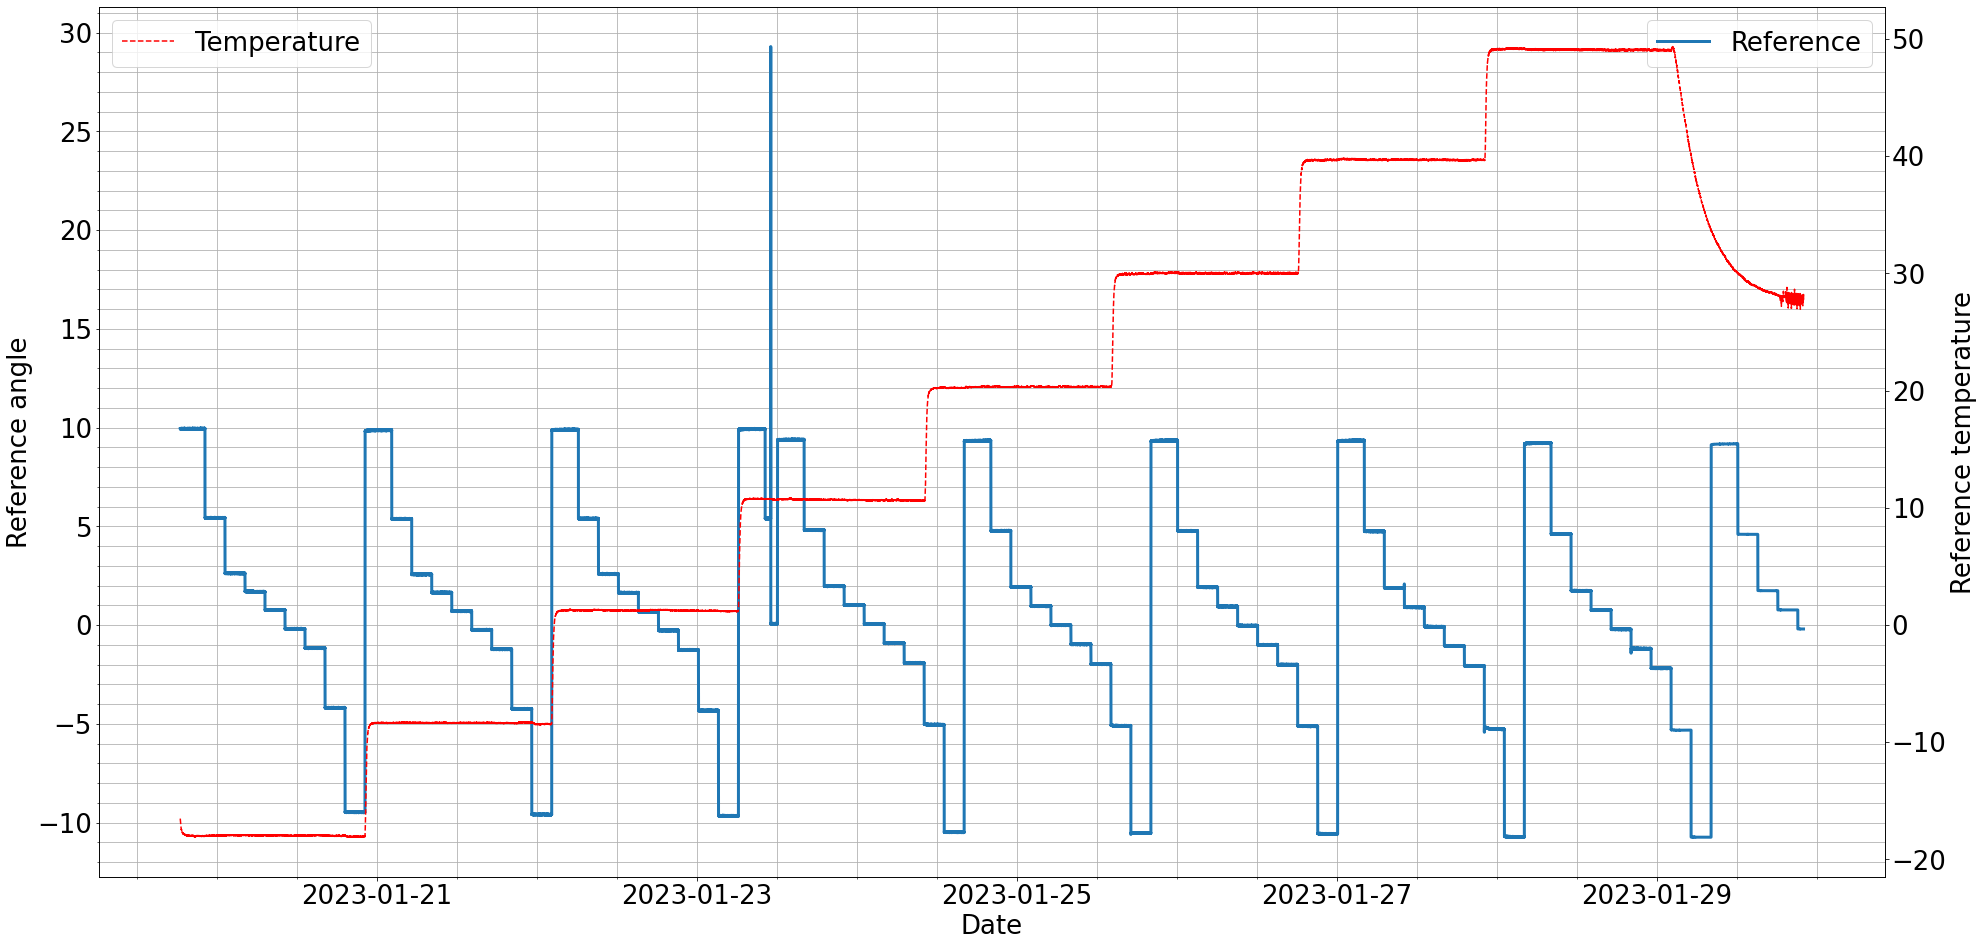

In [5]:
length = 0
for i in range(len(sb_numbers)): # Find which dataframe is most complete
    if len(analyser.dfs[i]) > length:
        length = len(analyser.dfs[i])
        number = i

fig,ax = plt.subplots(figsize=(32,16))
fig.set_facecolor('w')

ax.plot(analyser.refdf["Angle Y"], linewidth=3,label='Reference')
ax.set_xlabel("Date")
ax.set_ylabel("Reference angle")
ax.minorticks_on()
ax.grid(which='both', axis='both')
ax.legend(['Reference'], loc='upper right')

ax2 = ax.twinx()
ax2.plot(analyser.refdf["Temperature"], 'r--', label='JDI-200 temperature')
ax2.set_ylabel("Reference temperature")
ax2.legend(['Temperature'], loc='upper left')
plt.savefig('Figures\\Reference_full_plt.png',dpi='figure')
#plt.show()


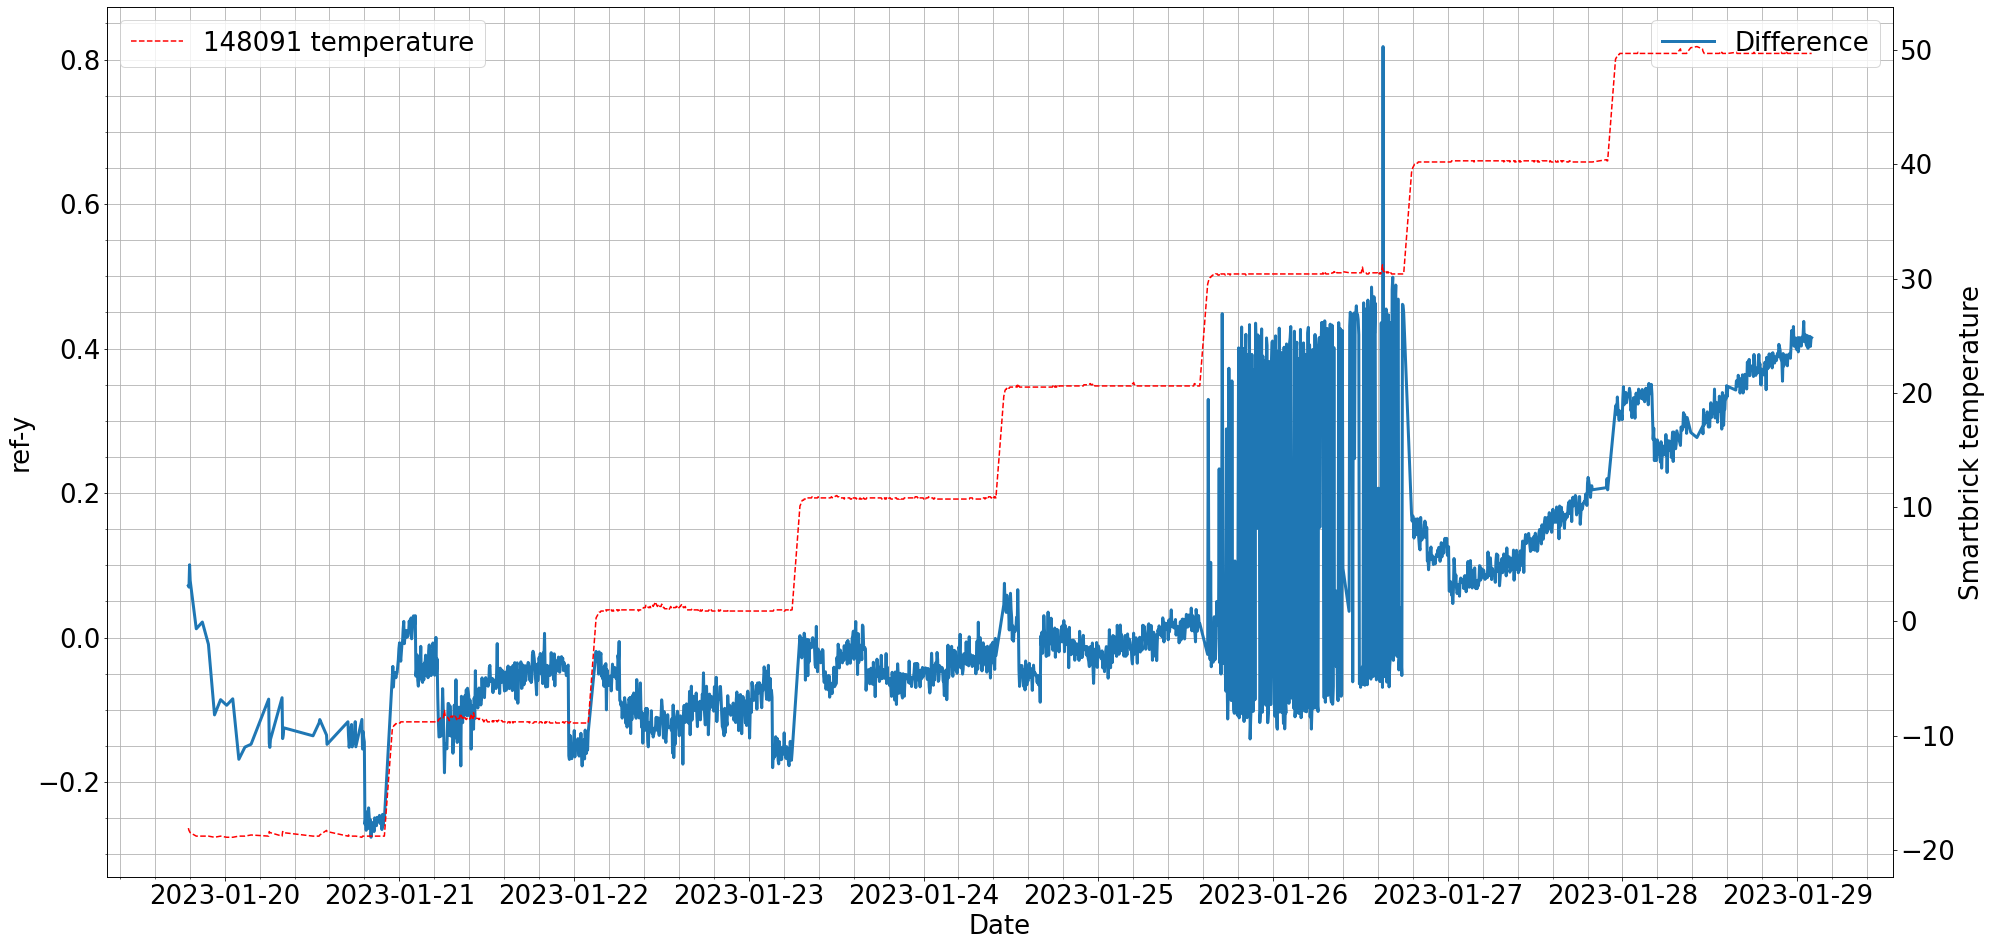

RMS error of  148091 :  0.17792936893349978  deg
Maximum error of  148091 :  0.8180476333090787  deg


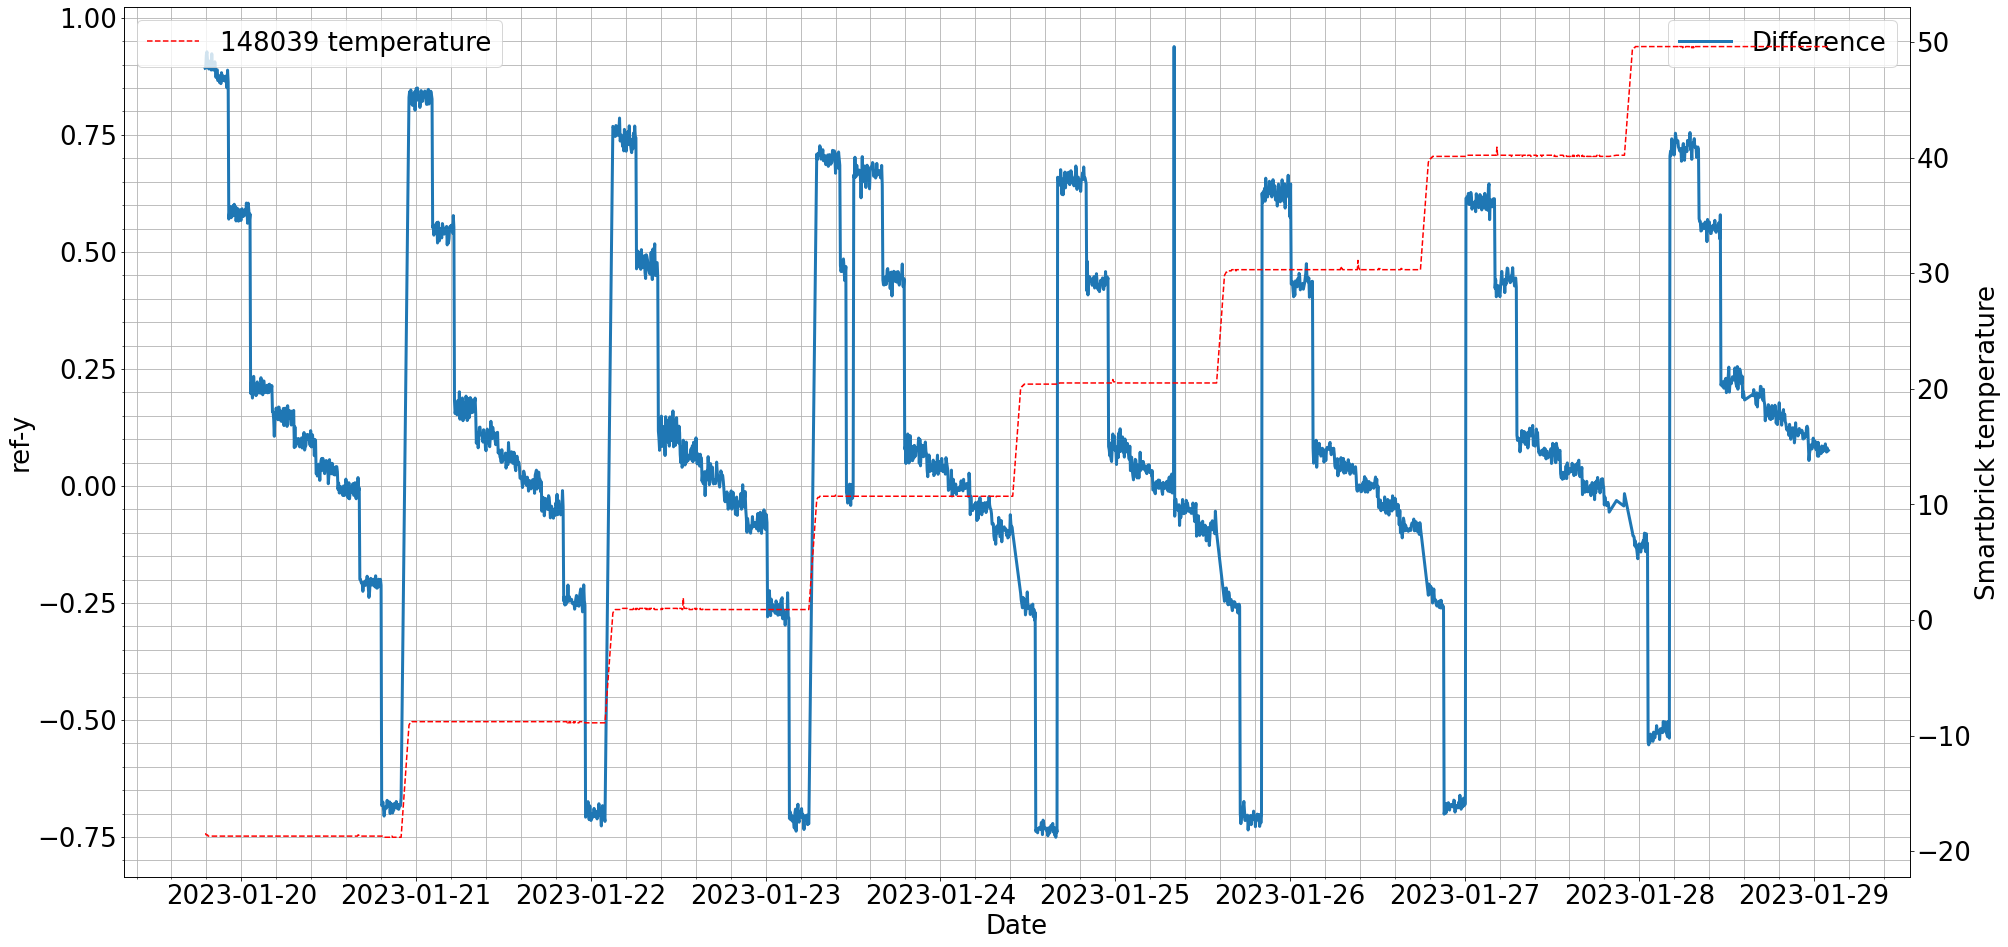

RMS error of  148039 :  0.40095367343276567  deg
Maximum error of  148039 :  0.9386671214529996  deg


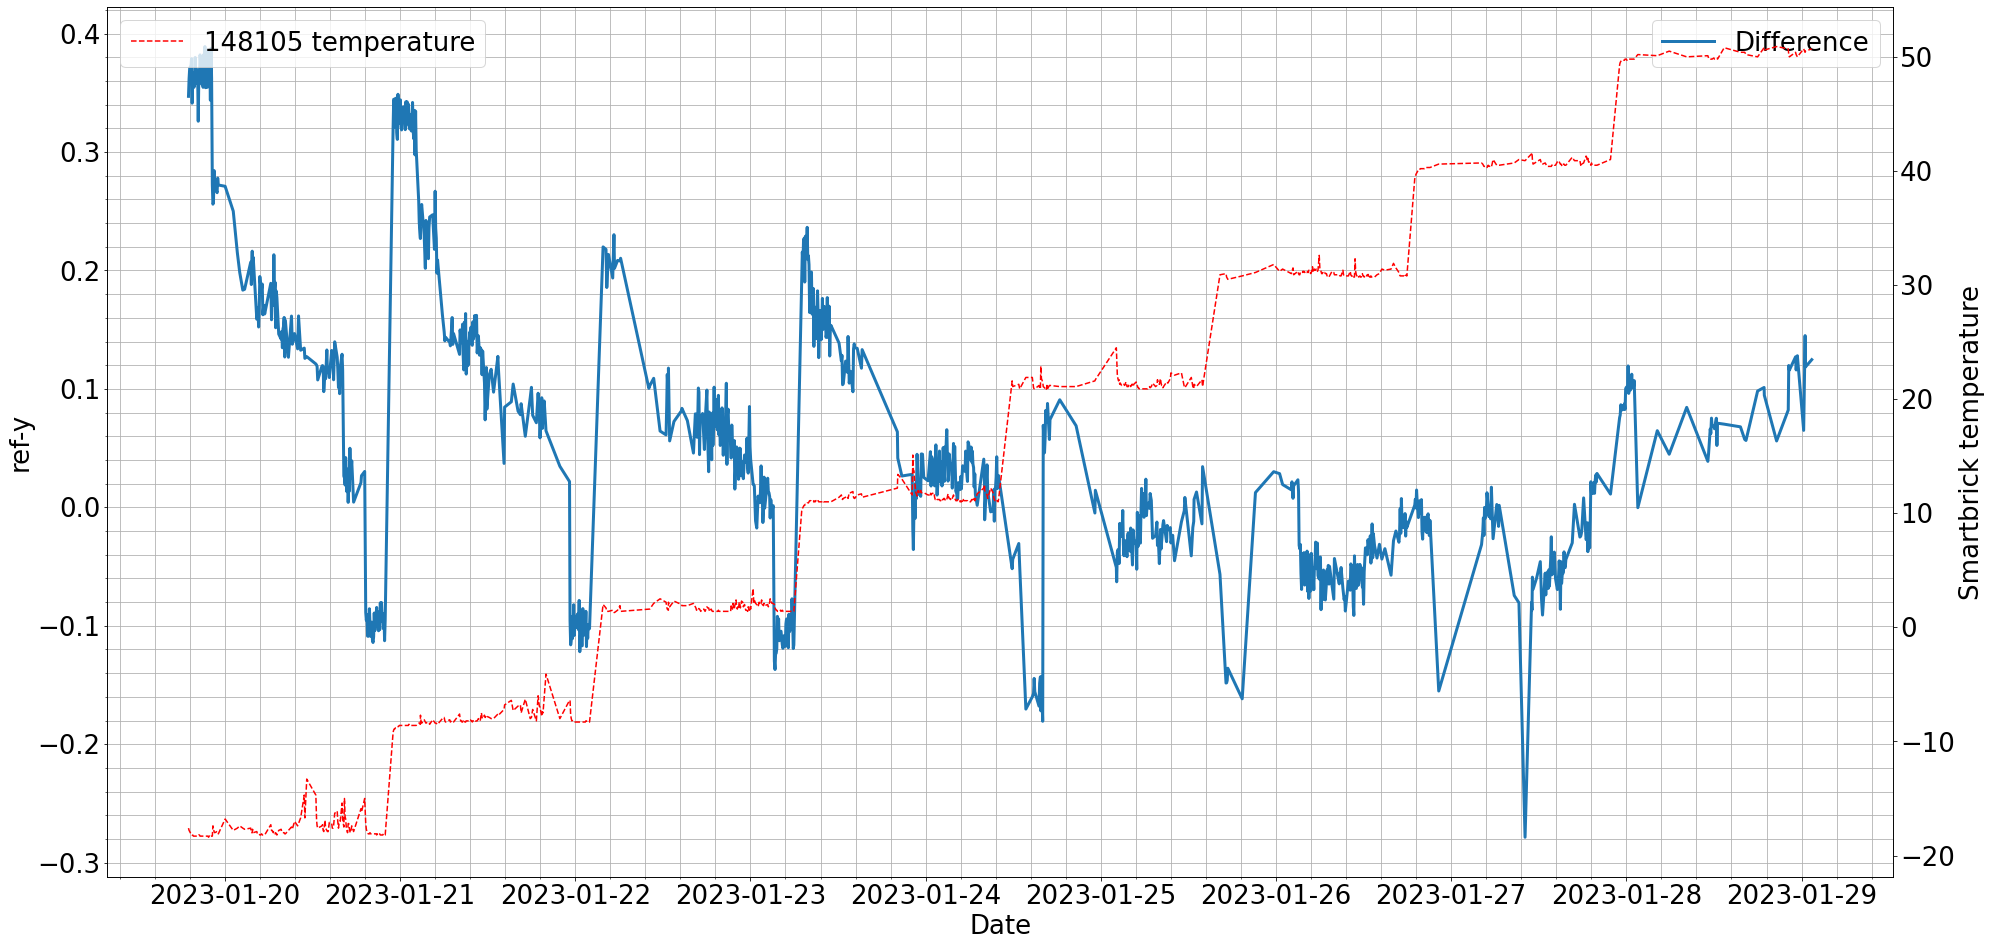

RMS error of  148105 :  0.1338074198067505  deg
Maximum error of  148105 :  0.38903815683813114  deg


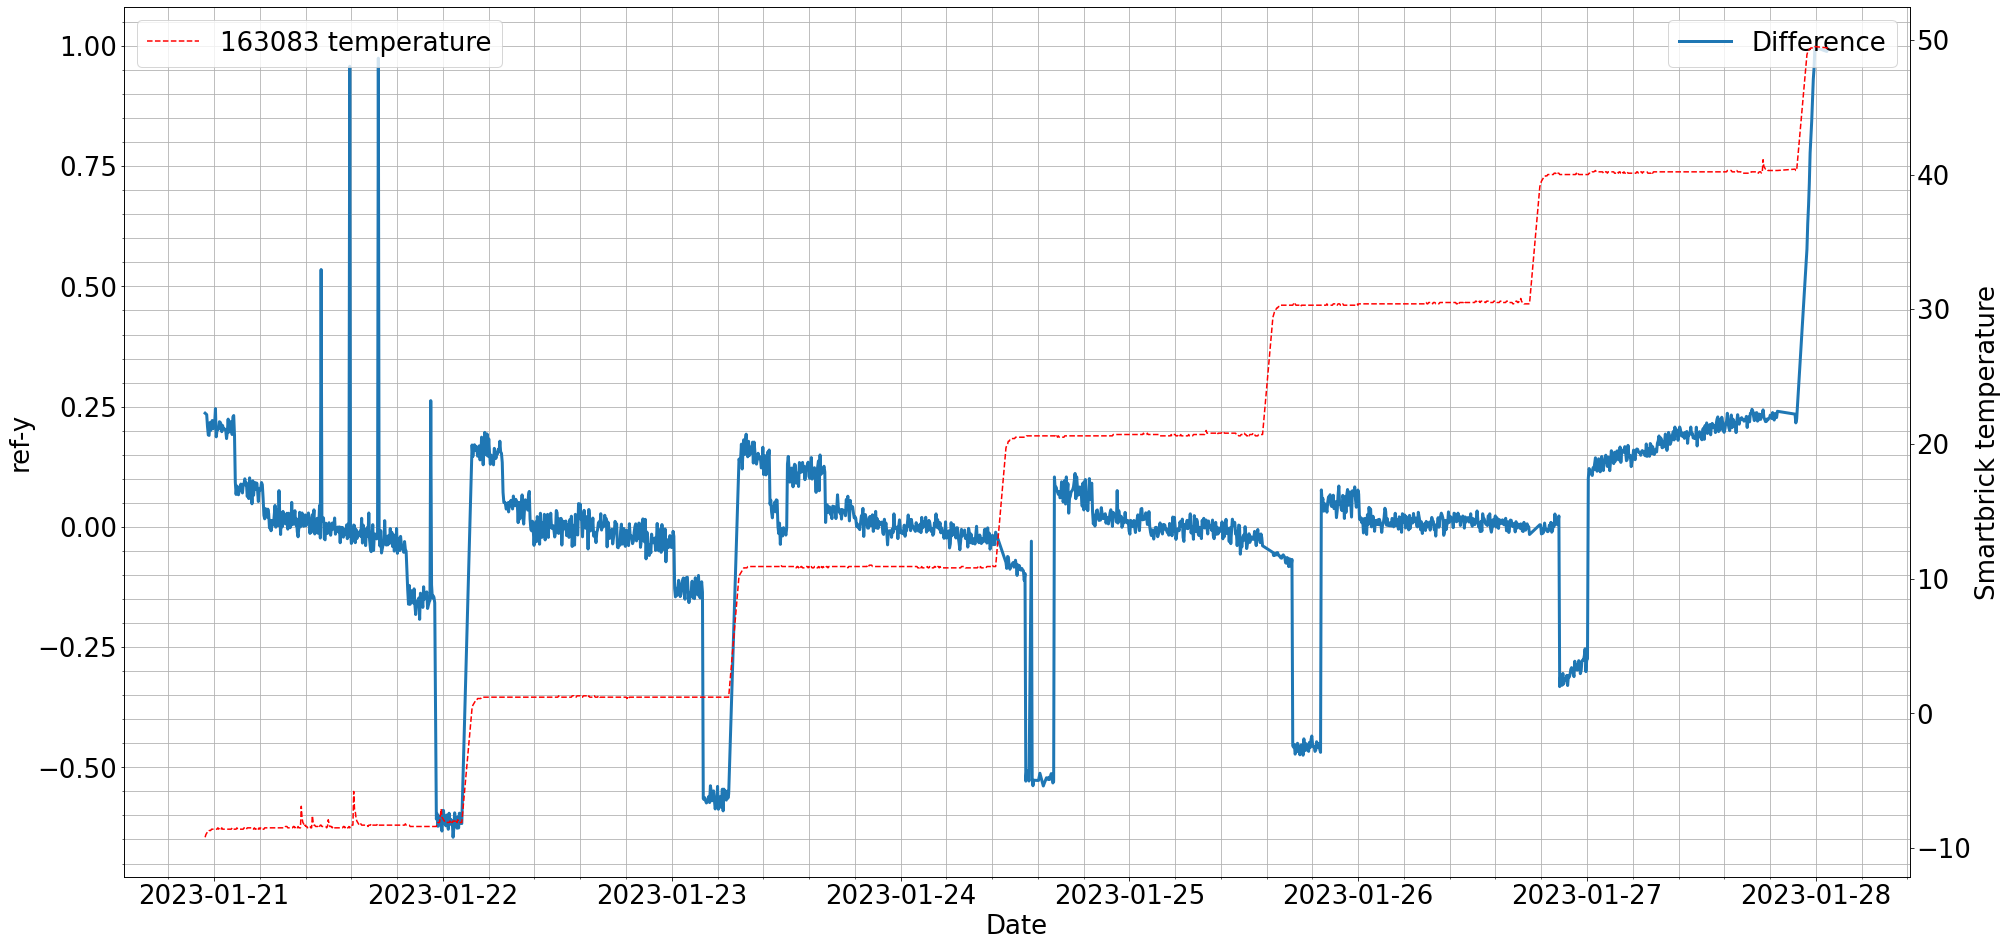

RMS error of  163083 :  0.18642095414773116  deg
Maximum error of  163083 :  0.9987358283469199  deg


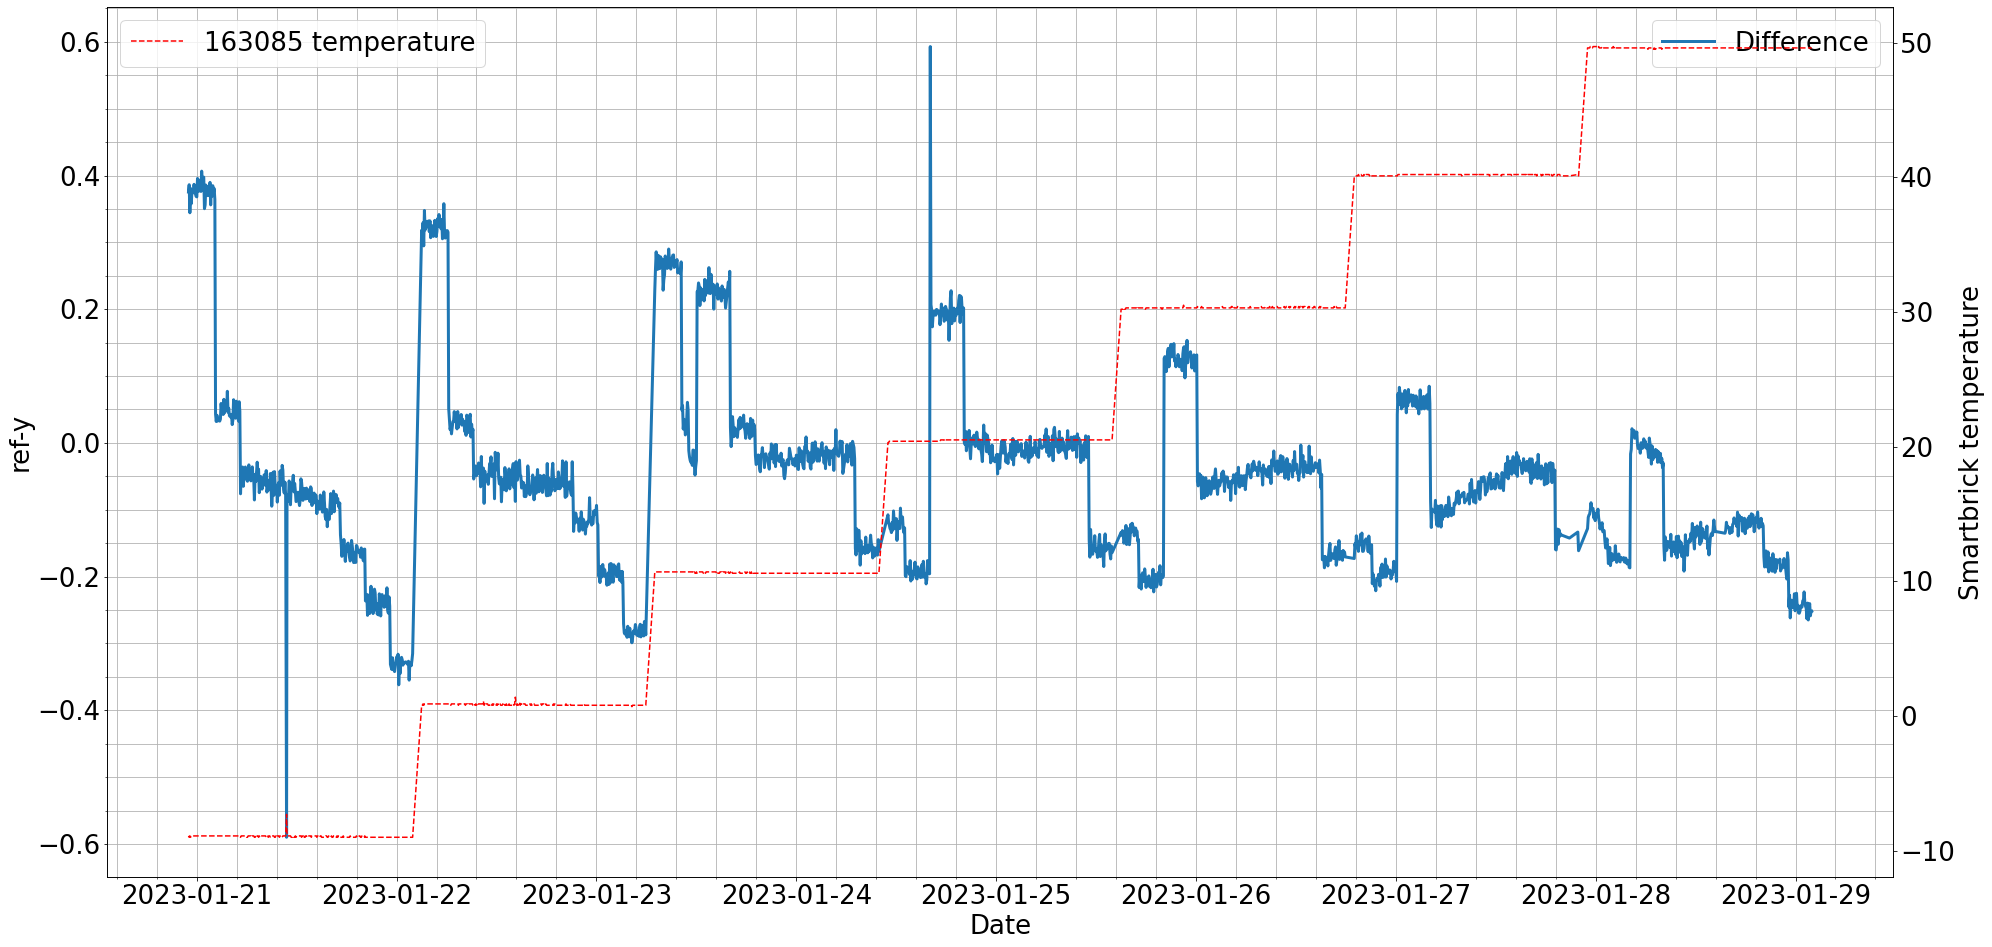

RMS error of  163085 :  0.1467785591687233  deg
Maximum error of  163085 :  0.5929643851706512  deg


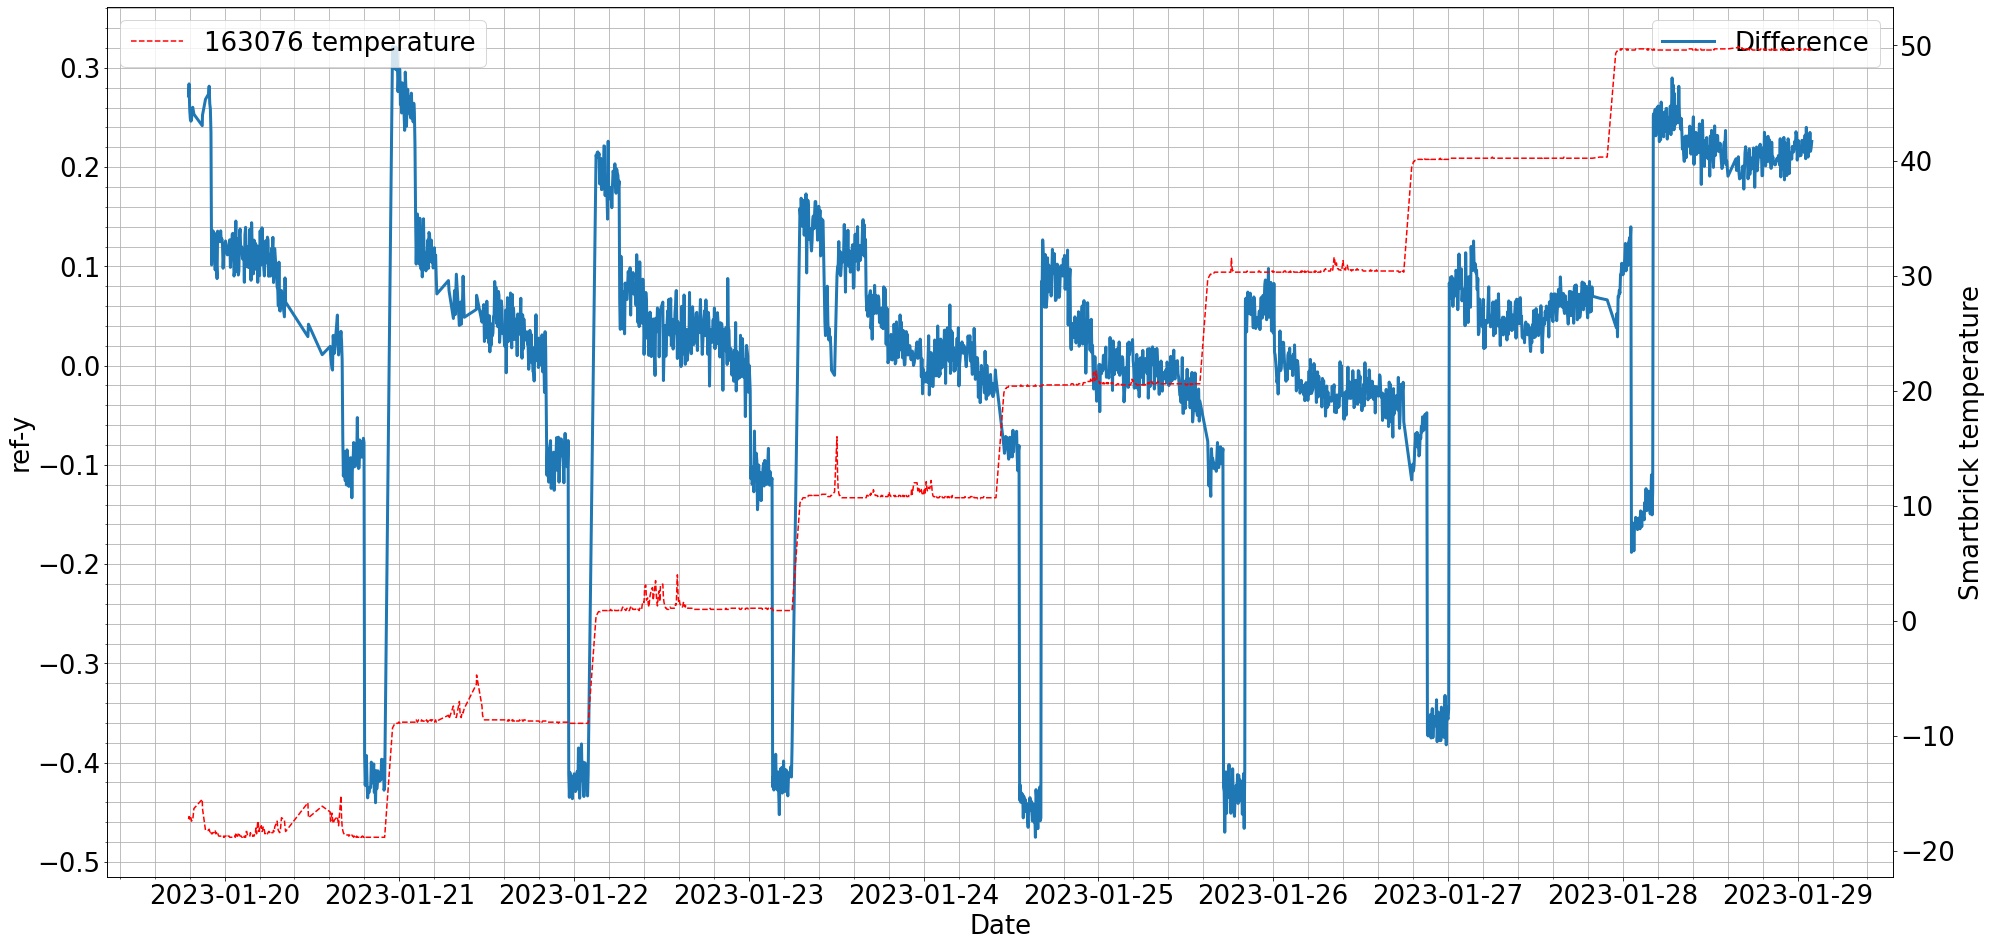

RMS error of  163076 :  0.16311880904757967  deg
Maximum error of  163076 :  0.4752078804543487  deg


In [6]:
for i in range(len(sb_numbers)):
    analyser.dfs[i]["Difference"] = (analyser.dfs[i]["Y value"] - analyser.dfs[i]["Reference"])

    fig,ax = plt.subplots(figsize=(32,16))
    fig.set_facecolor('w')

    ax.plot(analyser.dfs[i]["Difference"], linewidth=3,label='Difference')
    ax.set_xlabel("Date")
    ax.set_ylabel("ref-y")
    ax.minorticks_on()
    ax.grid(which='both', axis='both')
    ax.legend(['Difference'], loc='upper right')

    ax2 = ax.twinx()
    ax2.plot(analyser.dfs[i]["Temperature"], 'r--', label=str(sb_numbers[i])+' temperature')
    ax2.set_ylabel("Smartbrick temperature")
    ax2.legend([str(sb_numbers[i])+' temperature'], loc='upper left')
    plt.savefig('Figures\\Difference_'+str(sb_numbers[i])+'.png',dpi='figure')
    plt.show()

    # Performance evaluation
    RMS = sqrt((analyser.dfs[i]["Difference"]**2).mean())
    MAX = max(abs(analyser.dfs[i]["Difference"]))
    print("RMS error of ", sb_numbers[i], ": ", RMS, " deg")
    print("Maximum error of ", sb_numbers[i], ": ", MAX, " deg")

### Battery investigation
Below code plots for analysis of battery performance during the tests.

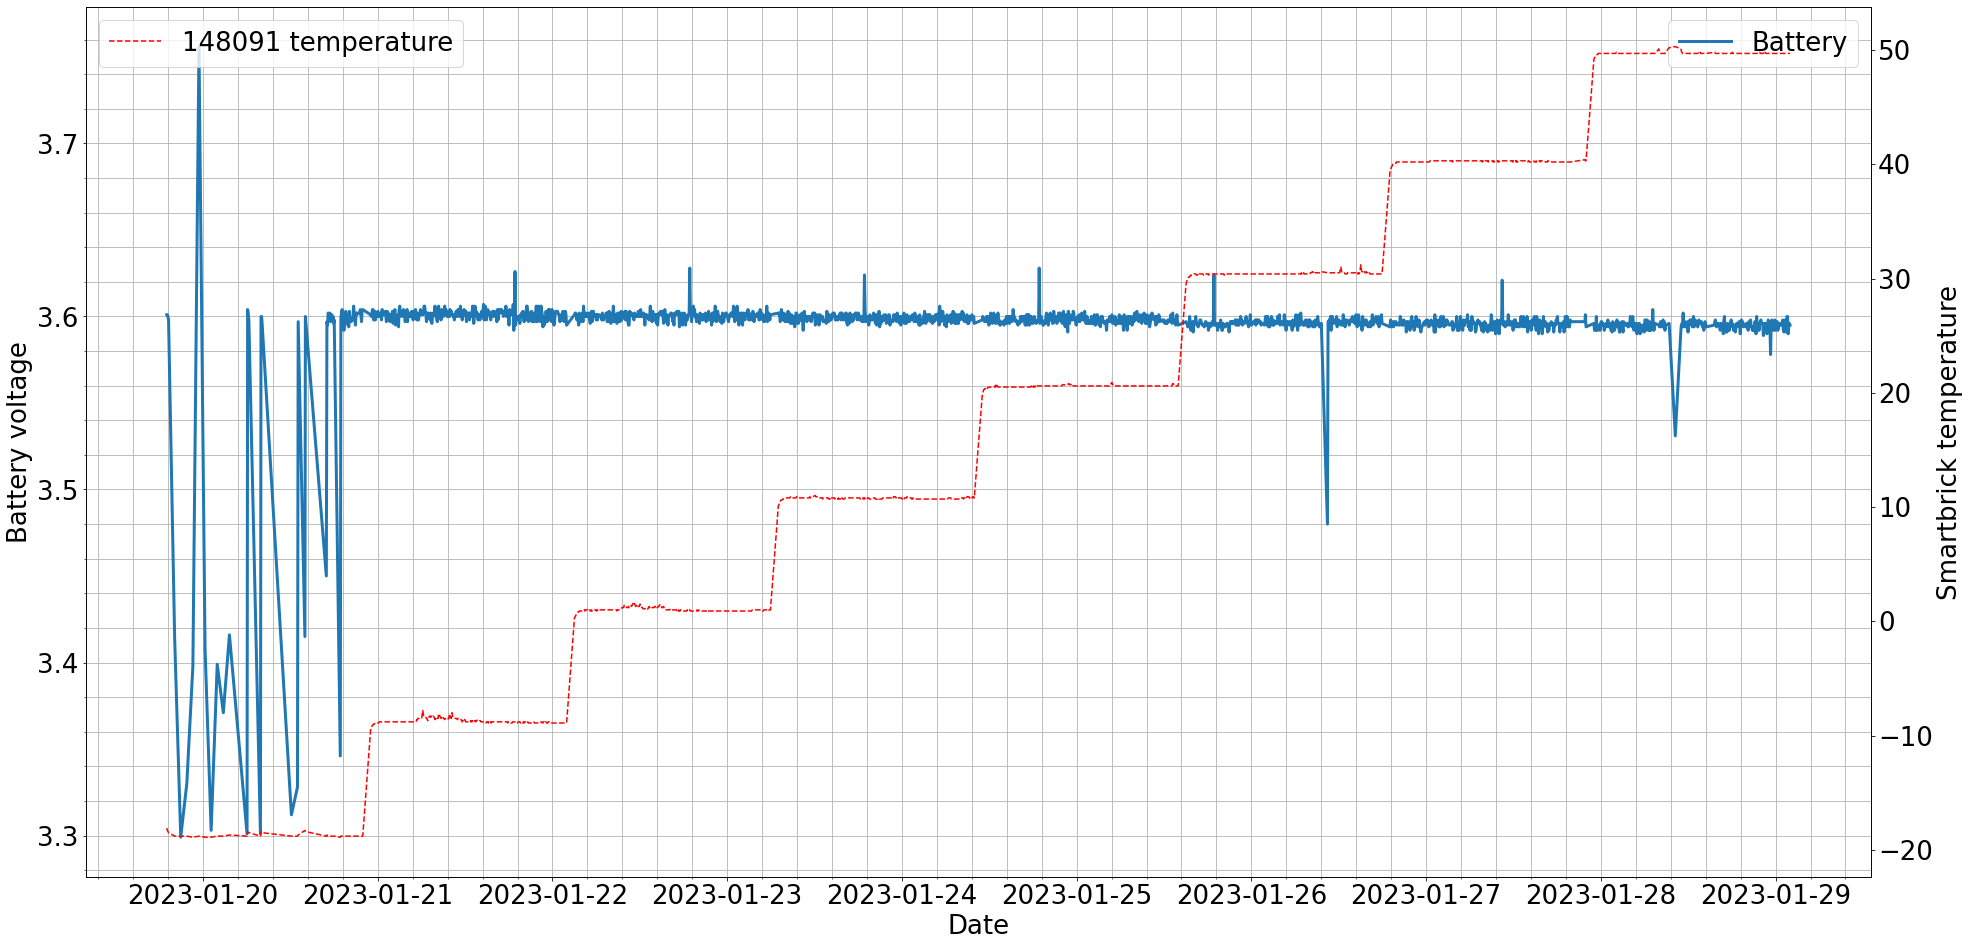

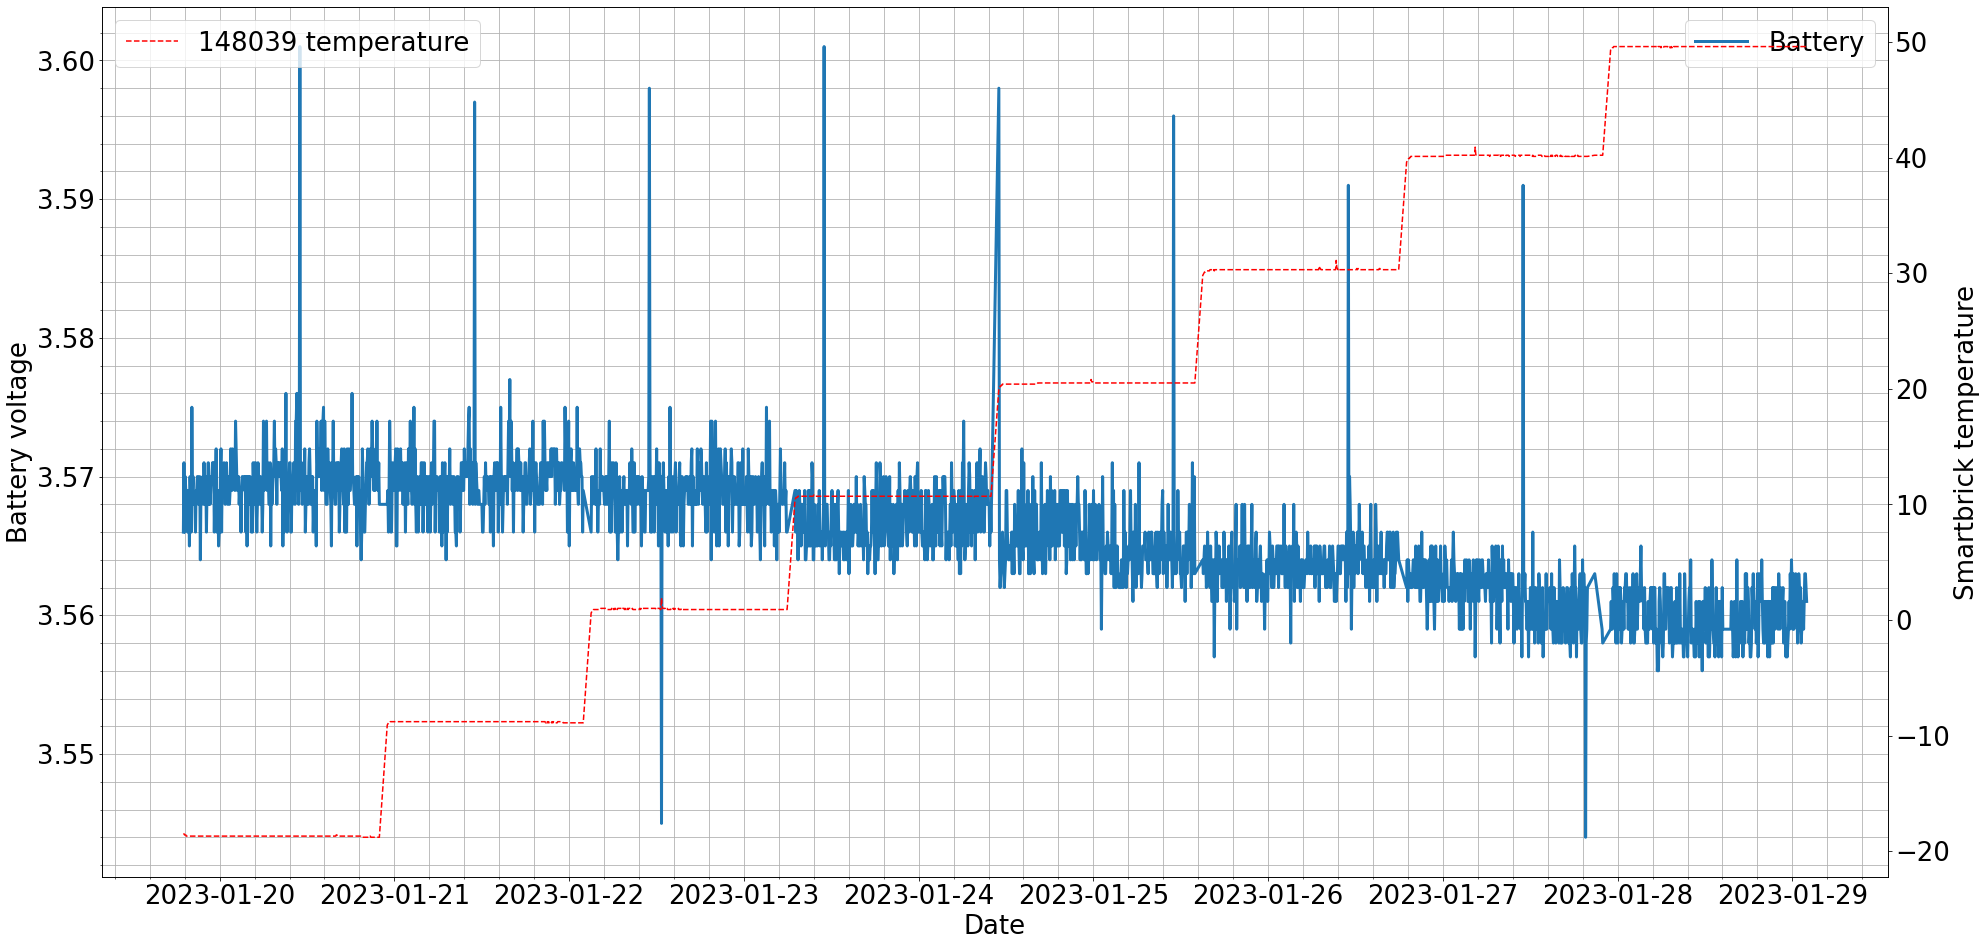

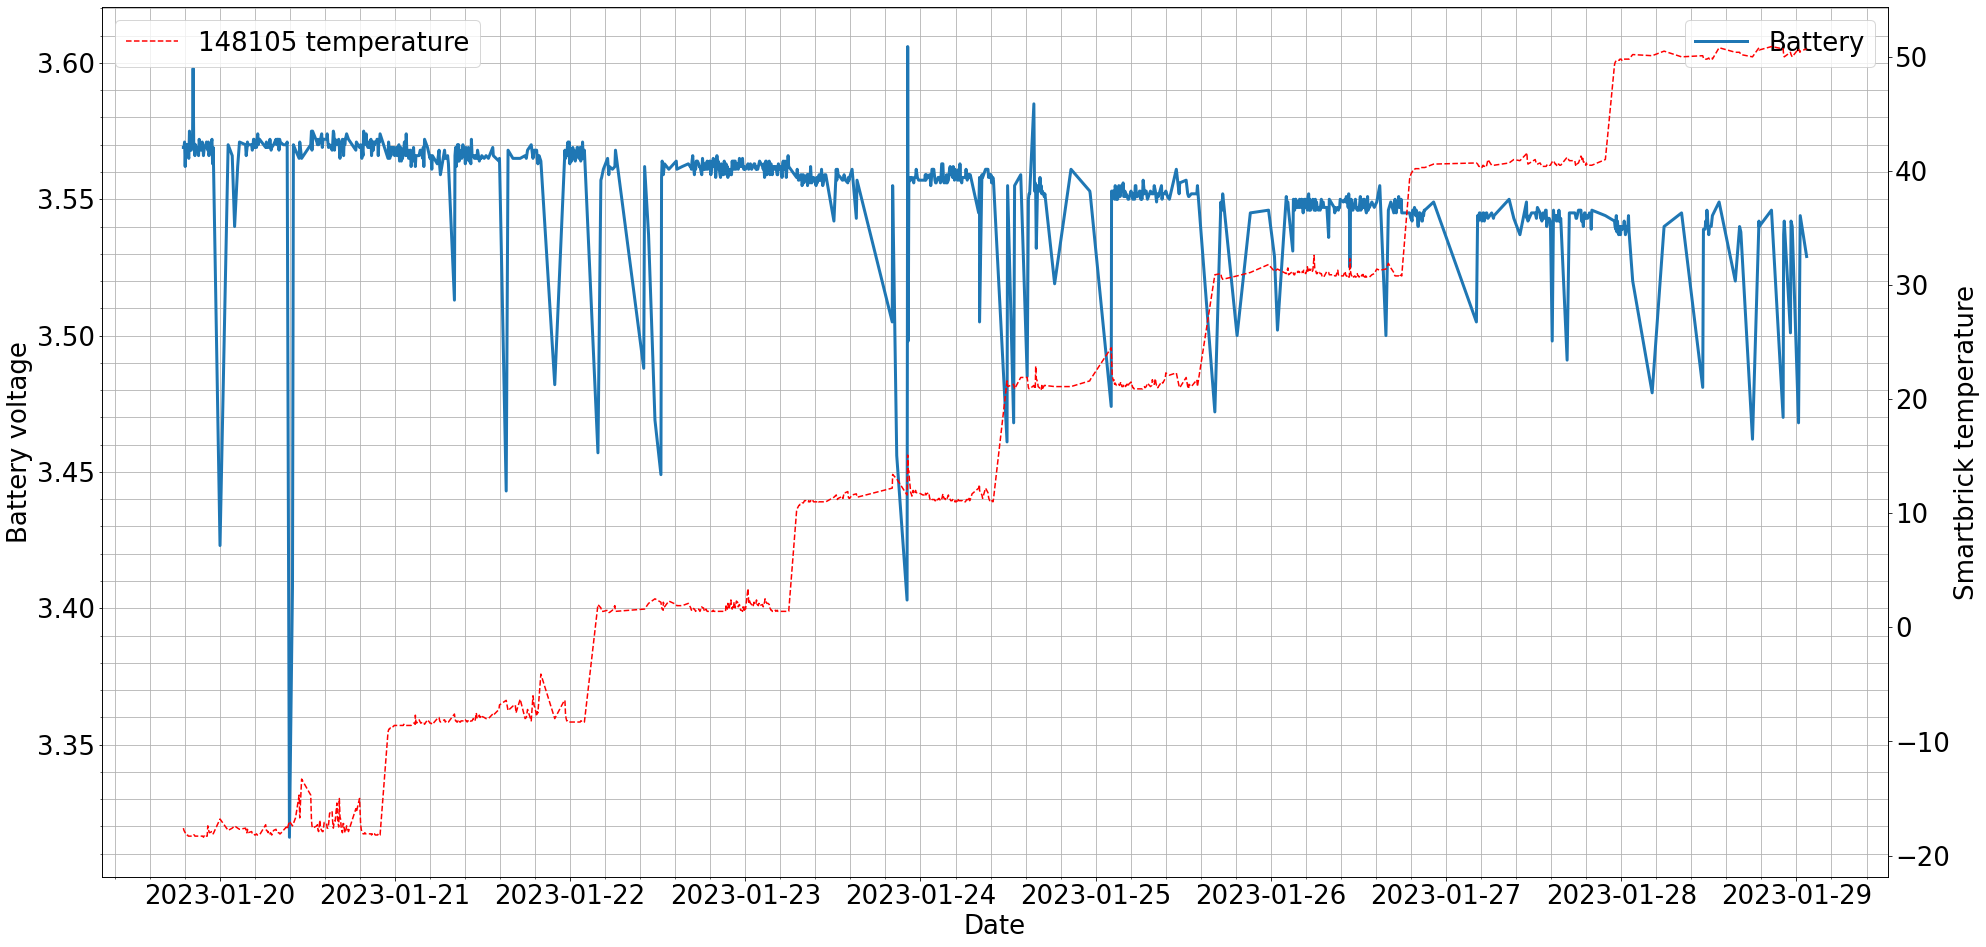

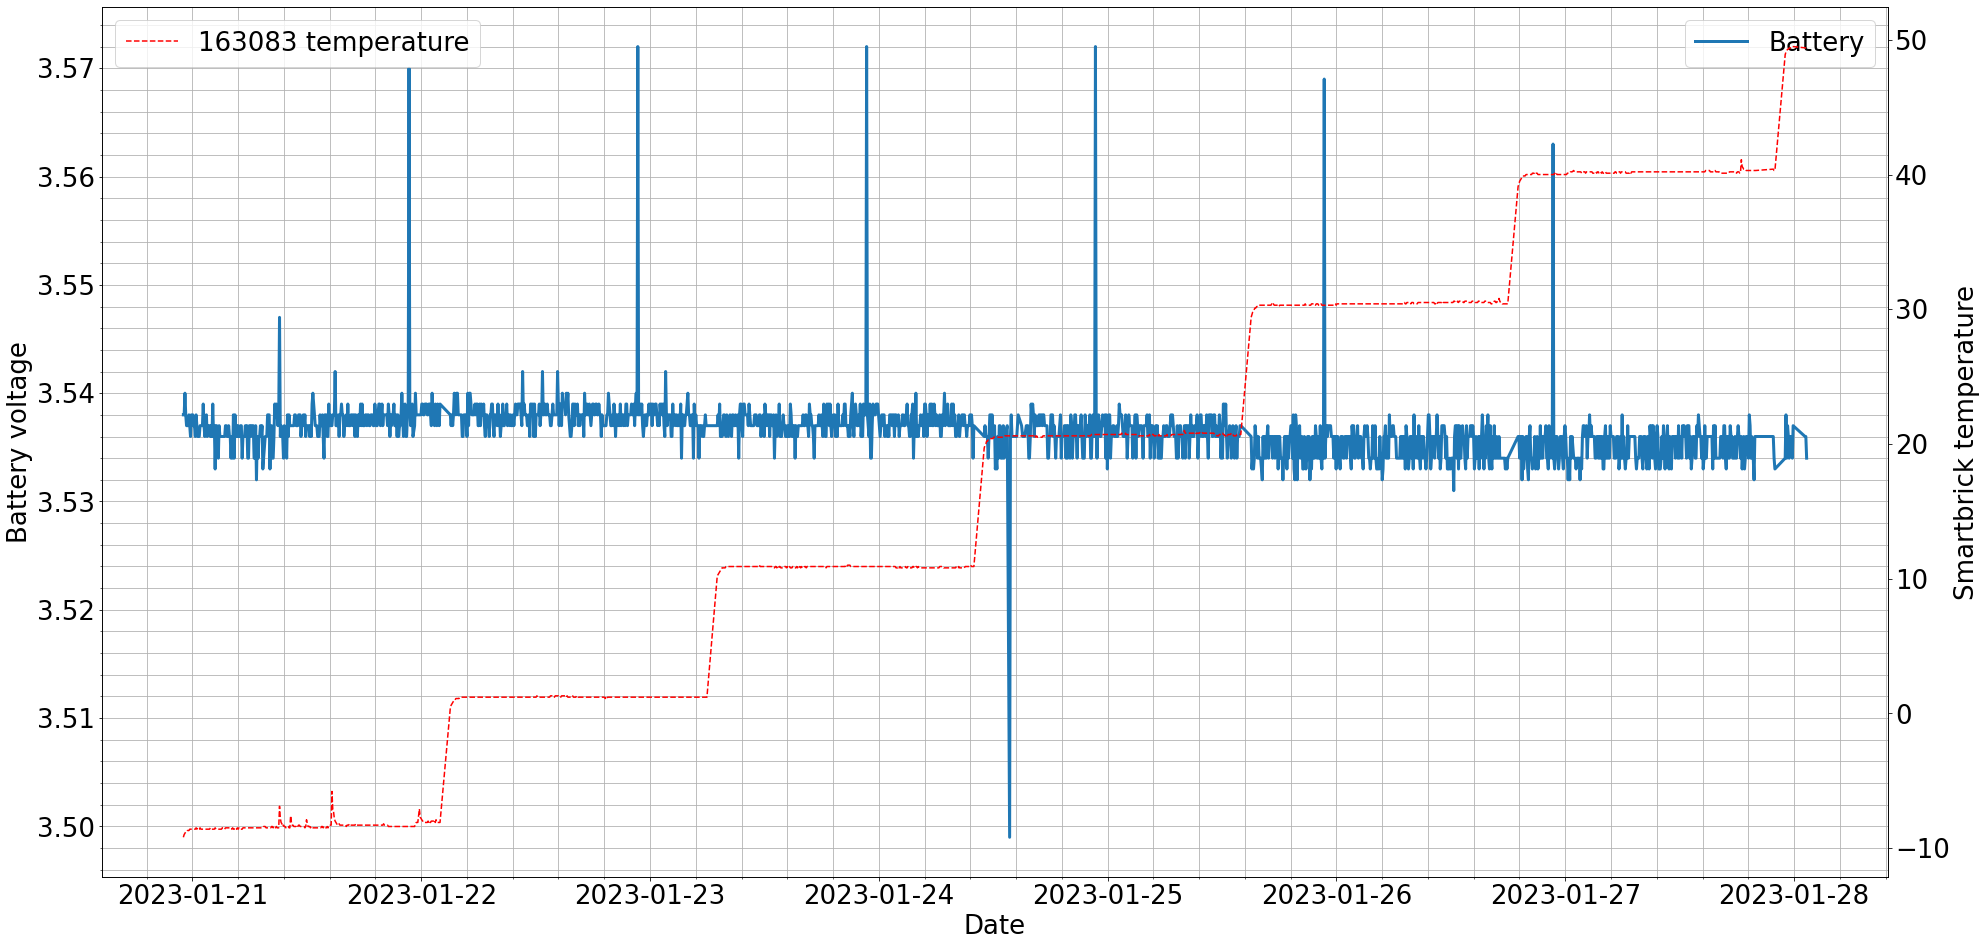

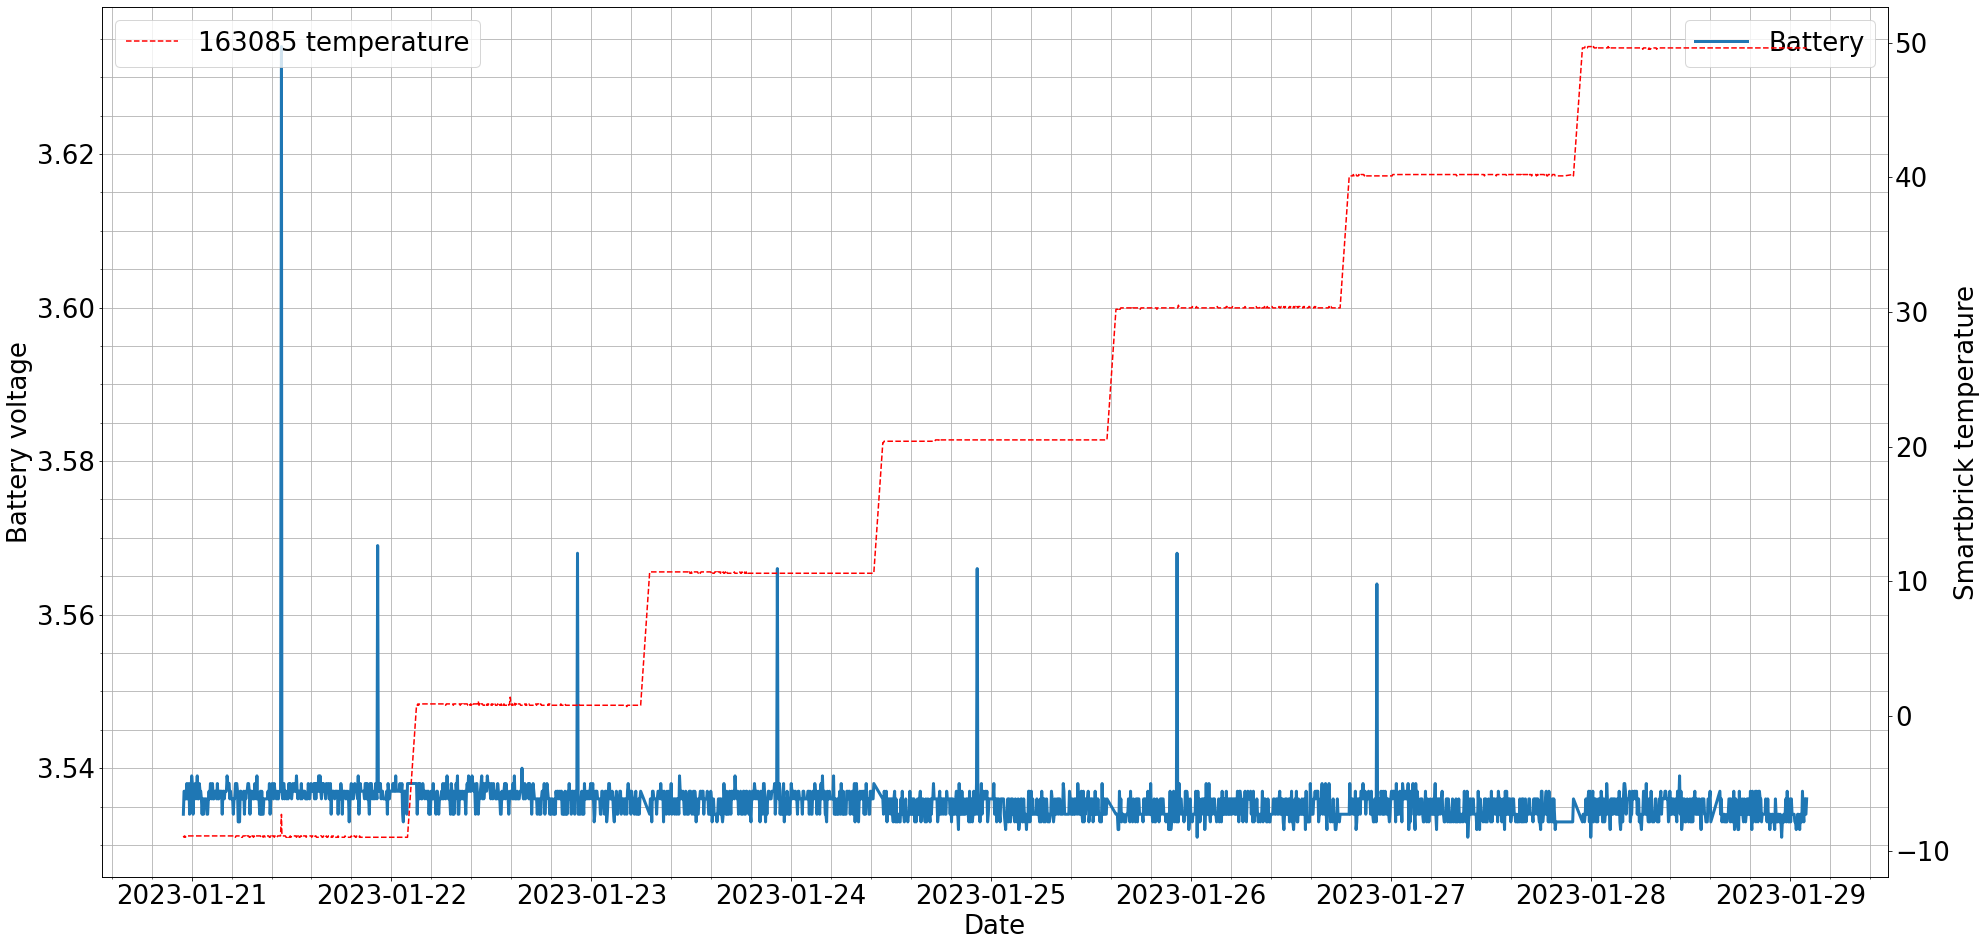

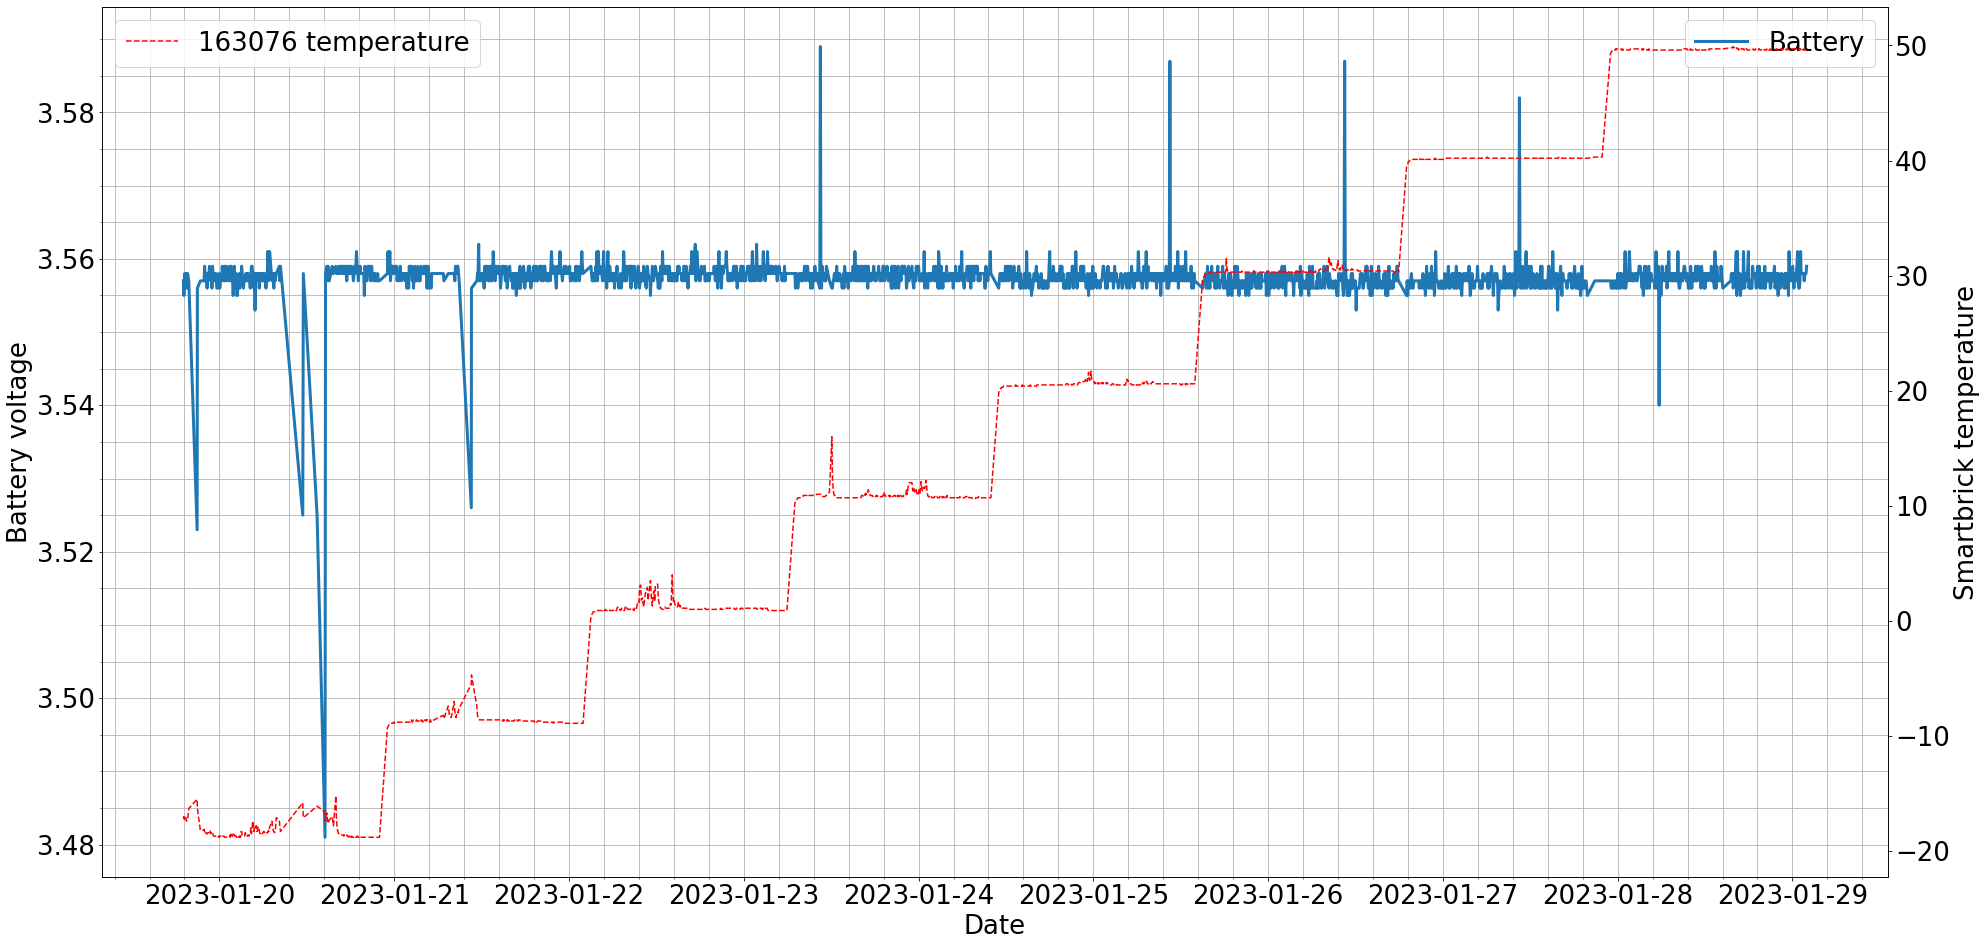

In [7]:
for i in range(len(sb_numbers)):
    fig,ax = plt.subplots(figsize=(32,16))
    fig.set_facecolor('w')

    ax.plot(analyser.dfs[i]["Battery"], linewidth=3,label='Battery')
    ax.set_xlabel("Date")
    ax.set_ylabel("Battery voltage")
    ax.minorticks_on()
    ax.grid(which='both', axis='both')
    ax.legend(['Battery'], loc='upper right')

    ax2 = ax.twinx()
    ax2.plot(analyser.dfs[i]["Temperature"], 'r--', label=str(sb_numbers[i])+' temperature')
    ax2.set_ylabel("Smartbrick temperature")
    ax2.legend([str(sb_numbers[i])+' temperature'], loc='upper left')
    plt.savefig('Figures\\Battery_'+str(sb_numbers[i])+'.png',dpi='figure')
    plt.show()

### Plotting inclination setting/temperature vs battery voltage
To find any correlations between angles or temperatures and the battery voltage, where low voltages are expected to indicate shorts on the PCB.

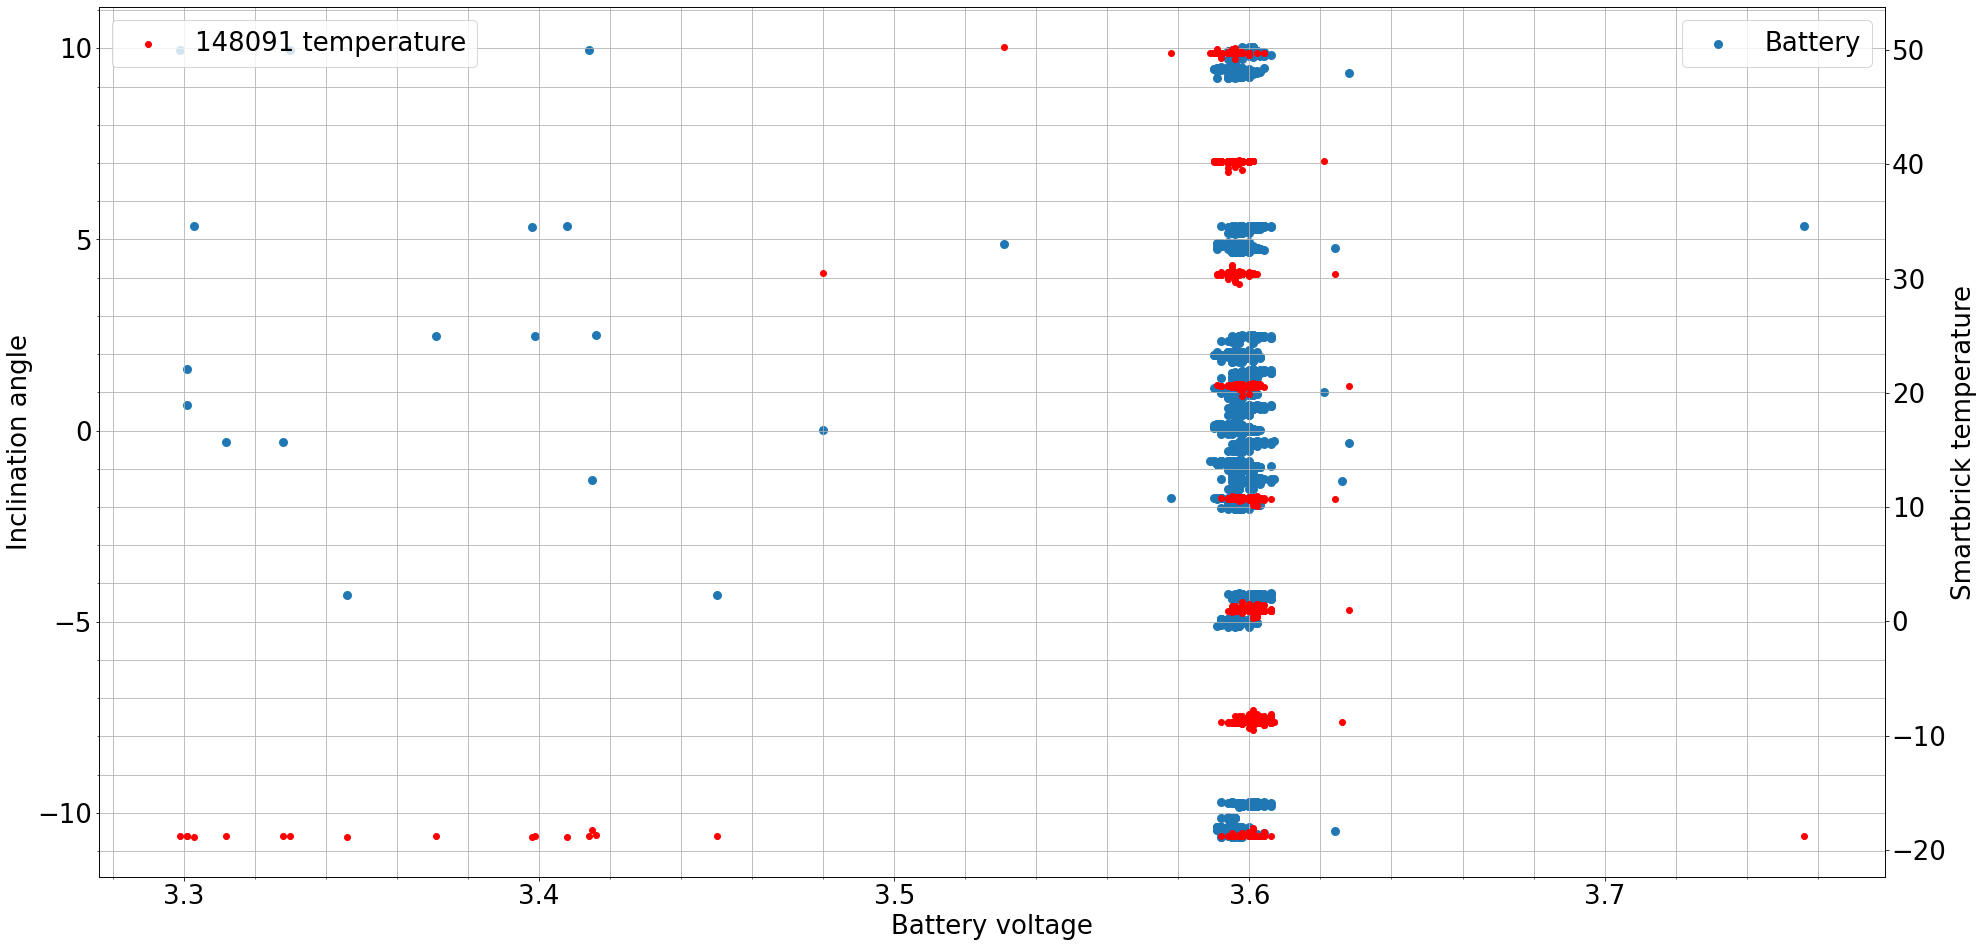

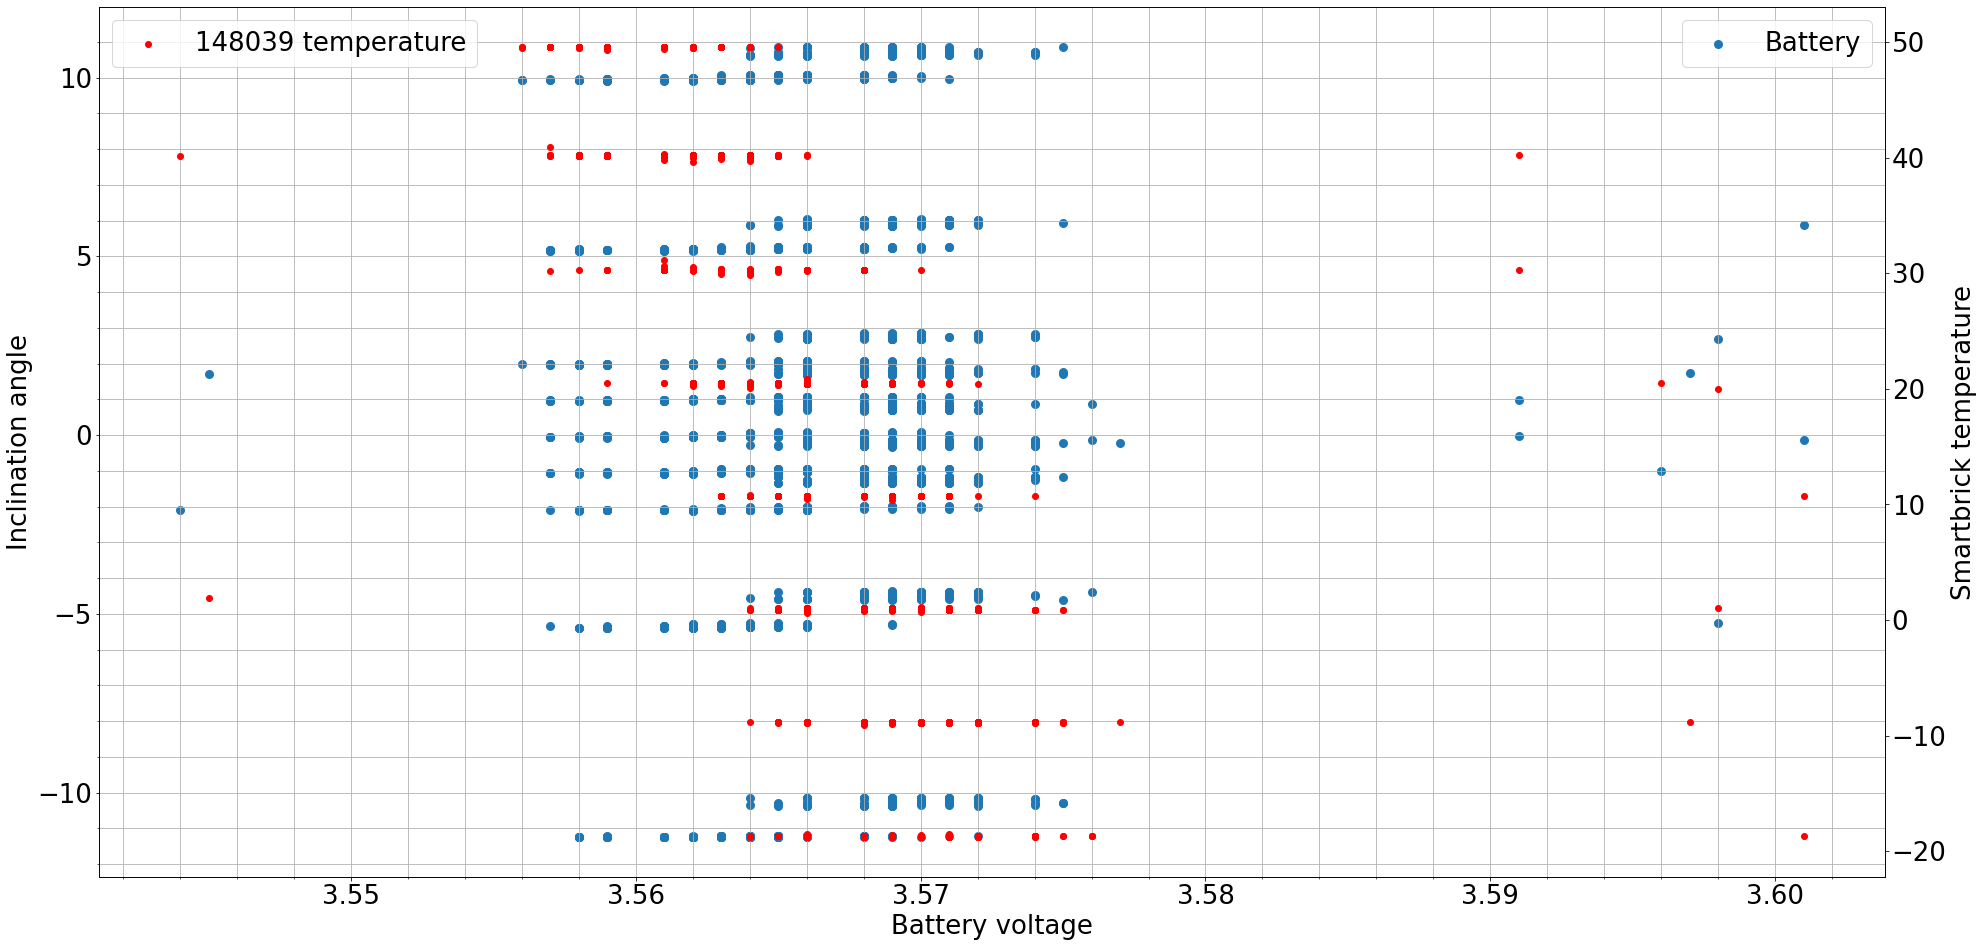

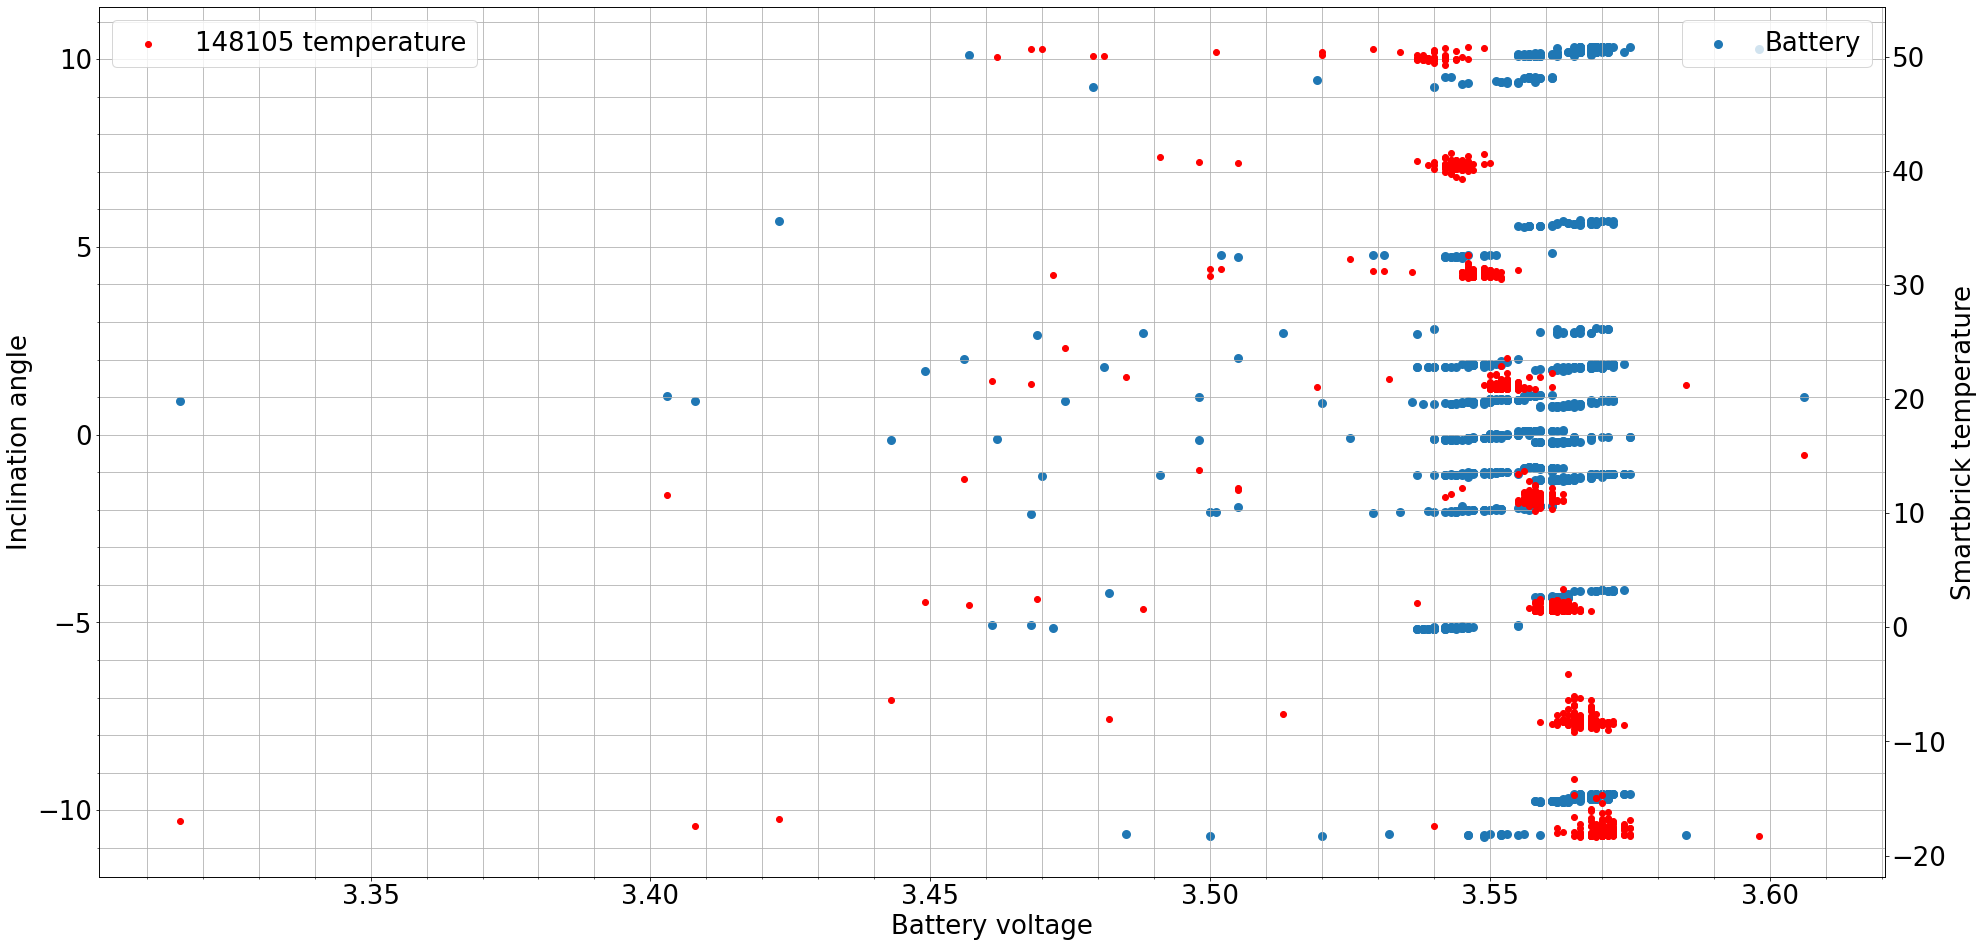

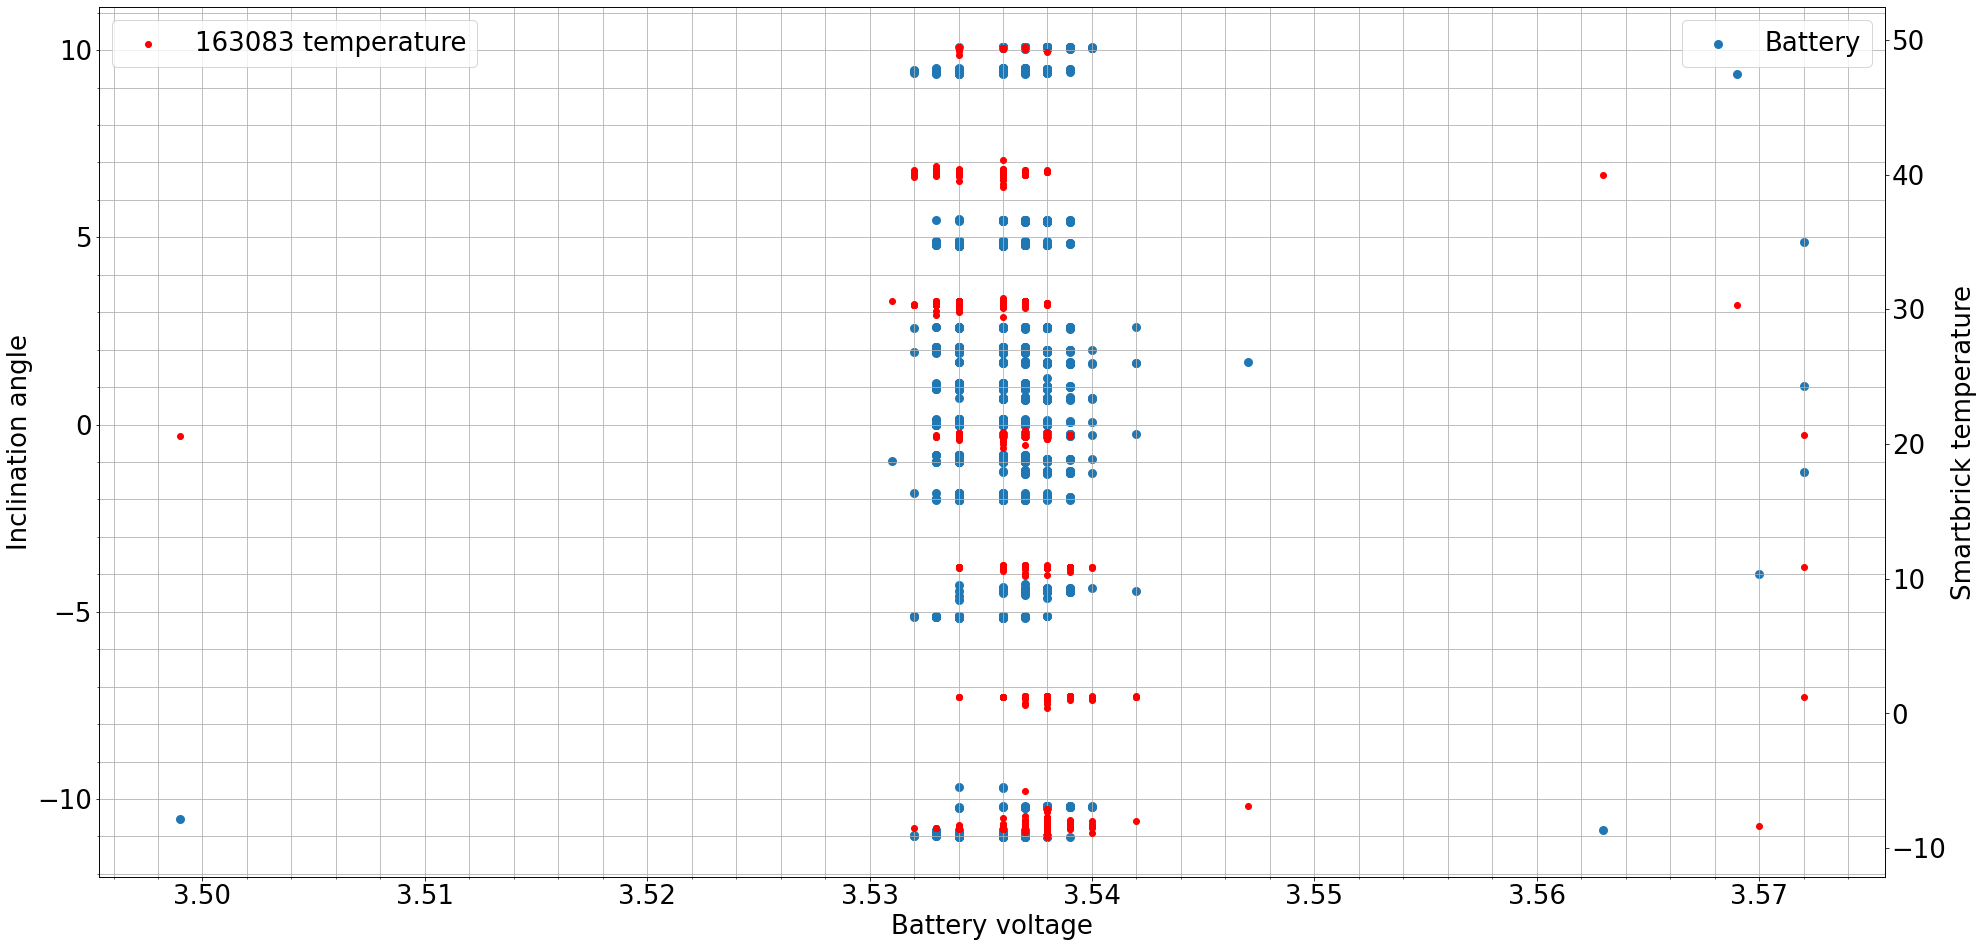

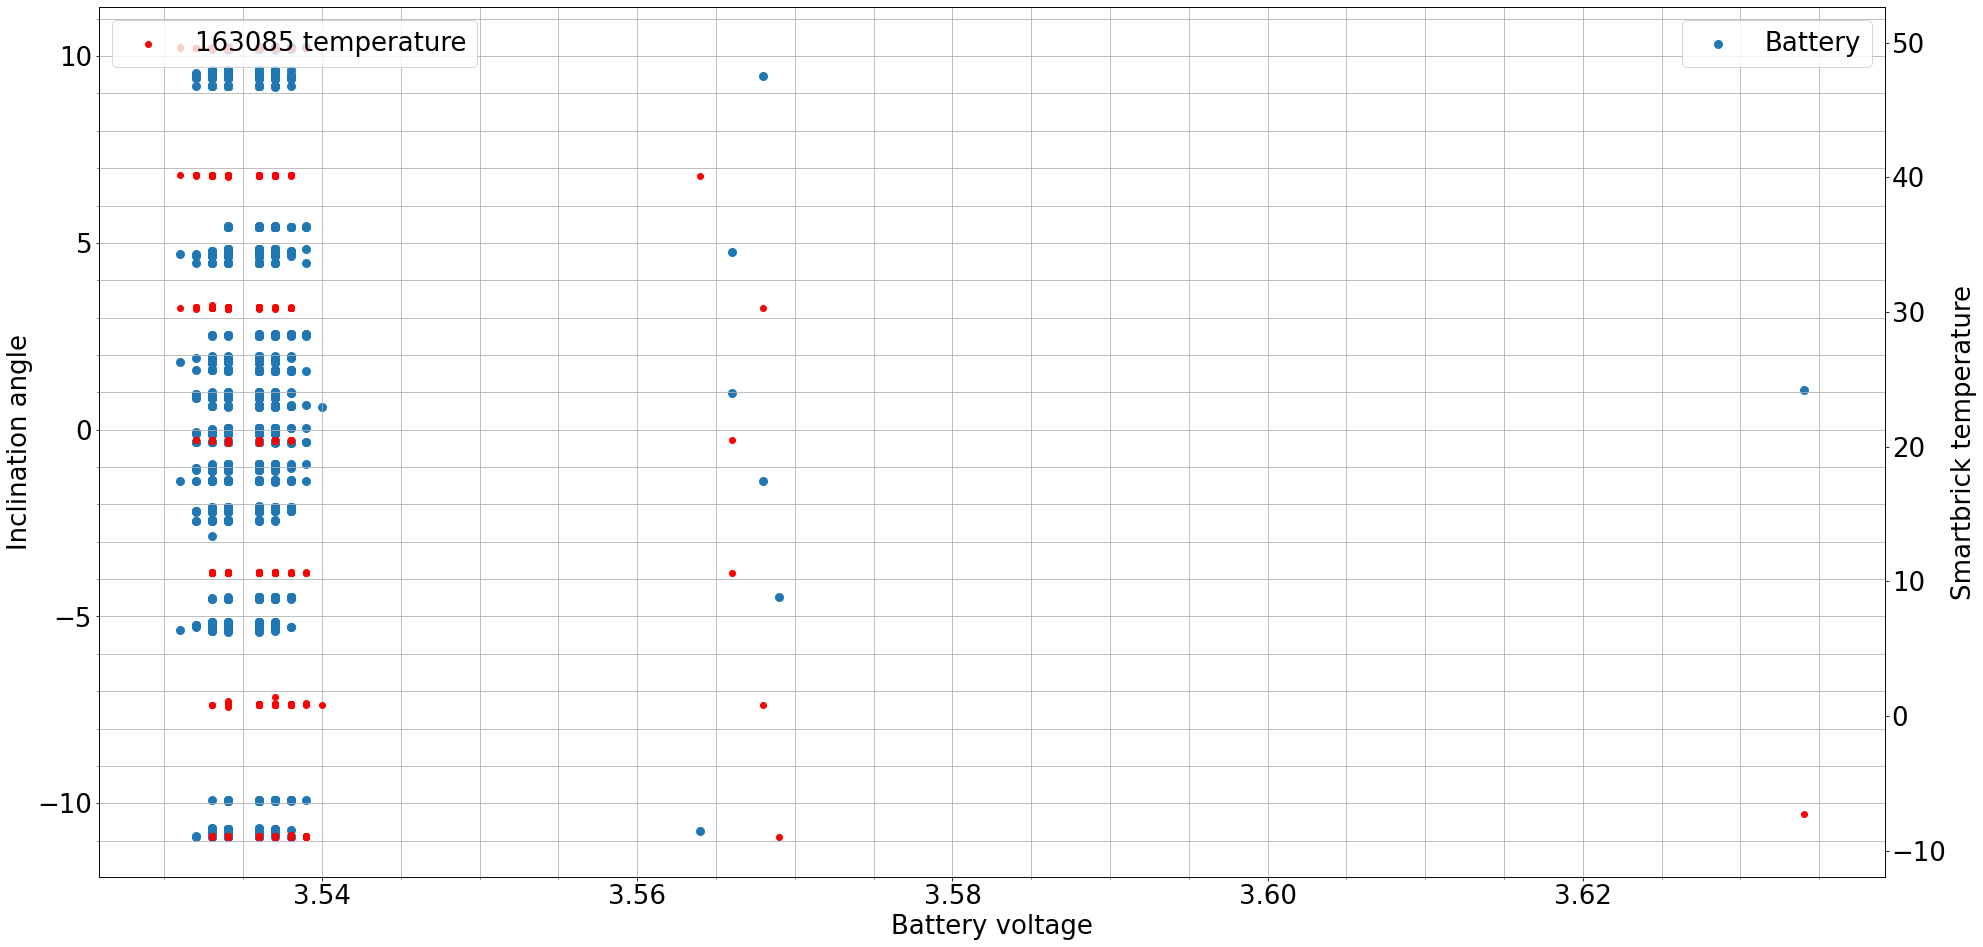

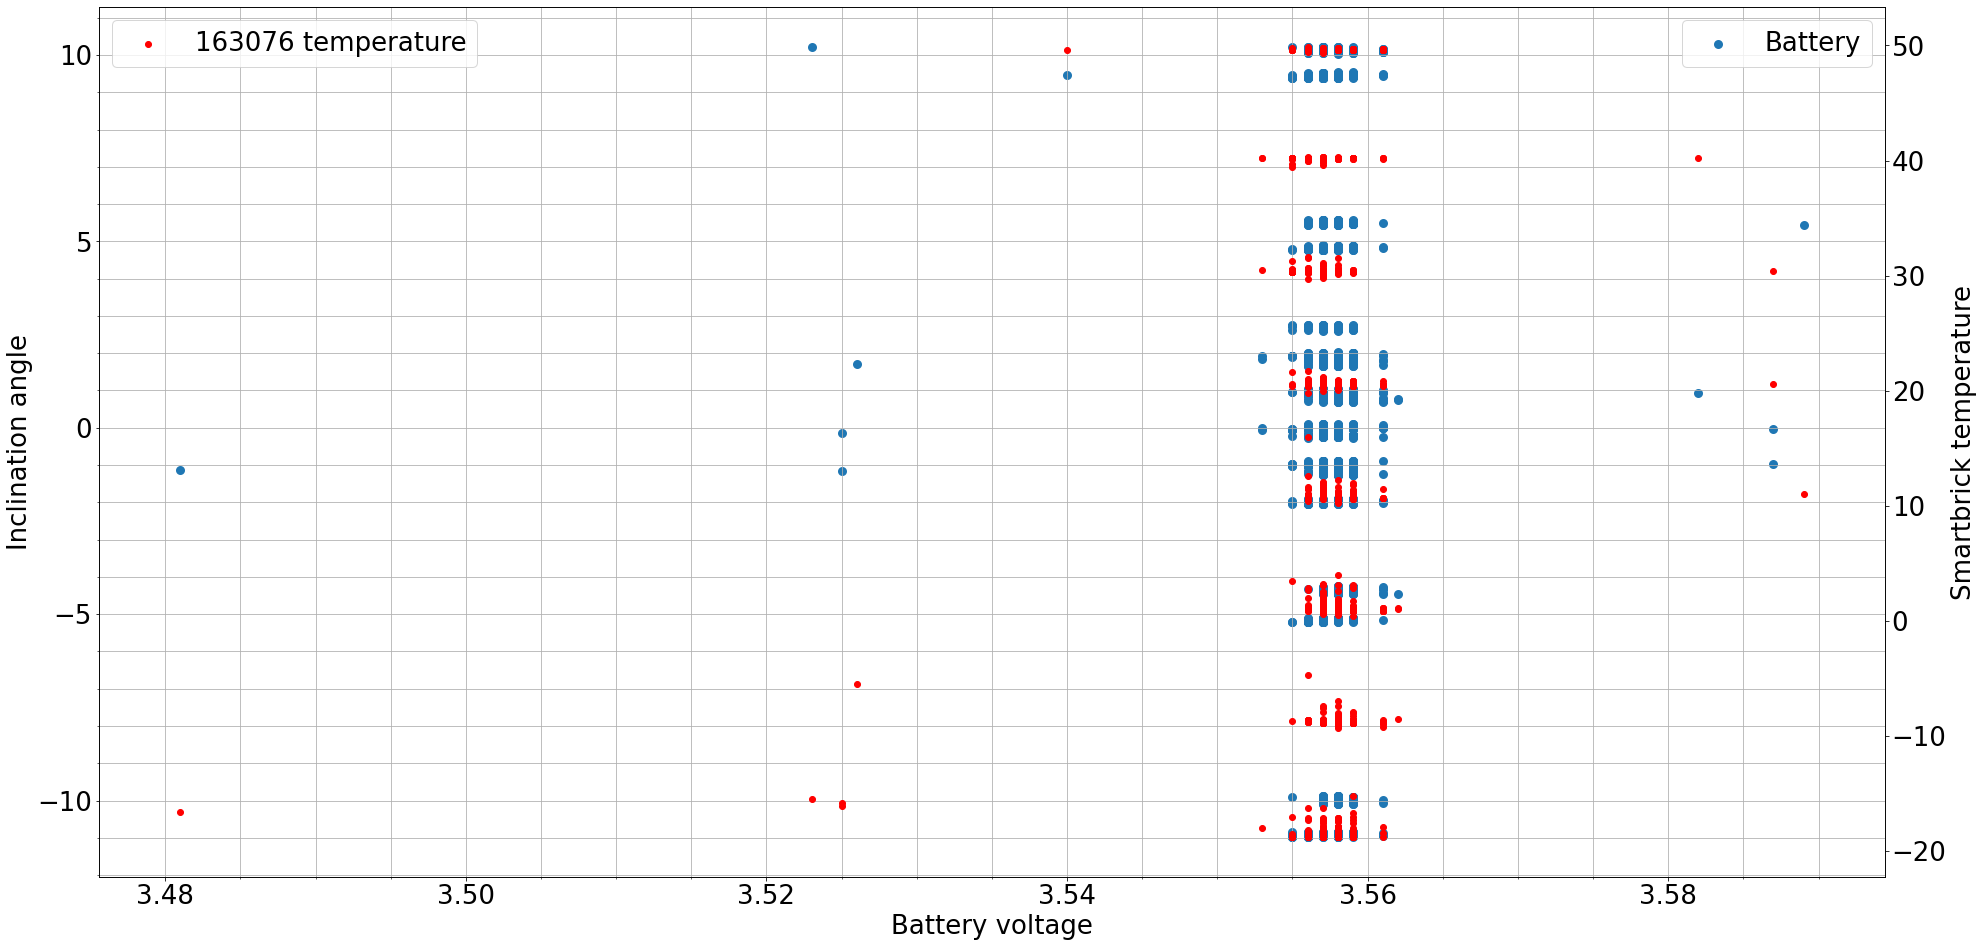

In [8]:
for i in range(len(sb_numbers)):
    fig,ax = plt.subplots(figsize=(32,16))
    fig.set_facecolor('w')

    ax.scatter(analyser.dfs[i]["Battery"], analyser.dfs[i]["Y value"], linewidth=3,label='Battery')
    ax.set_xlabel("Battery voltage")
    ax.set_ylabel("Inclination angle")
    ax.minorticks_on()
    ax.grid(which='both', axis='both')
    ax.legend(['Battery'], loc='upper right')

    ax2 = ax.twinx()
    ax2.scatter(analyser.dfs[i]["Battery"], analyser.dfs[i]["Temperature"], c='r',label=str(sb_numbers[i])+' temperature')
    ax2.set_ylabel("Smartbrick temperature")
    ax2.legend([str(sb_numbers[i])+' temperature'], loc='upper left')
    plt.savefig('Figures\\Scatter'+str(sb_numbers[i])+'.png',dpi='figure')
    plt.show()

## Determining model coefficients
One of the later tests will see if the individual calibration helps. One smartbrick has been hung on the side of the Althen building at 2023-03-20 12:00. The code below determines the coefficients of the model.

Polynomial fit, inputs and references NOT standard transformed
Feature names:  ['1' 'x0' 'x1' 'x0^2' 'x0 x1' 'x1^2']
Model coefficients:  [ 0.00763725 -0.02838881  0.00271261  0.00140314  0.00025987 -0.00012342]
x1 = temp, x0 = meas angle


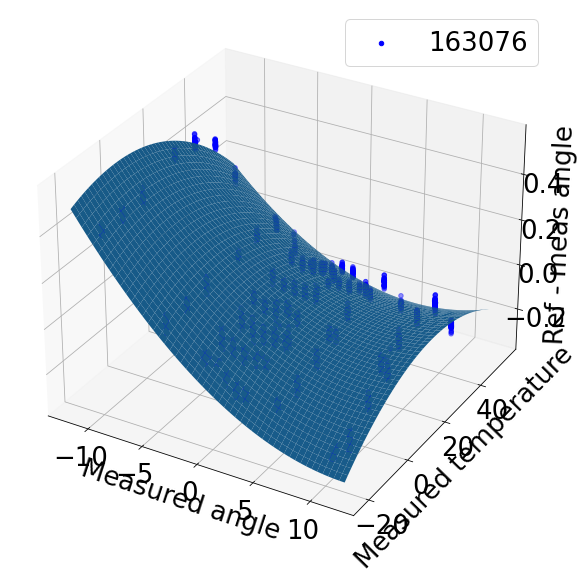

<Figure size 432x288 with 0 Axes>

In [9]:
# Determining the model coefficients
# Reload data
test_start_datetime = "2023-01-19 18:30:00"
test_end_datetime = "2023-01-29 22:00:00"

analyser = blockbaxAnalyser(sb_numbers = [163076], 
plot_from_date=test_start_datetime, 
plot_till_date=test_end_datetime)

analyser.bins_y = bins_refy
analyser.bins_temp = bins_temp
analyser.y_steps = y_steps
analyser.temp_steps = temp_steps

analyser.loadData()
analyser.loadRefData(filename = os.path.join(os.path.abspath('').removesuffix('blockbaxAnalyser.py'),"Ref","jewell_ref_control.txt"))
analyser.determineOffsets(offset_date_start,offset_date_end)
analyser.cleanData()
analyser.matchRefData()
analyser.groupData()
i = 0

reflist = []
print("Polynomial fit, inputs and references NOT standard transformed") 

poly = PolynomialFeatures(degree = analyser.poly_degree)       
ylist = analyser.dfs[i]['Y value'].tolist()
templist = analyser.dfs[i]['Temperature'].tolist()

#reflist = analyser.dfs[i]['Reference'].tolist() # Predicts reference
reflist = (analyser.dfs[i]['Reference']-analyser.dfs[i]['Y value']).tolist() # Predicts error

indep_vars = np.transpose(np.array([ylist, templist]))
dep_vars = np.array(reflist)

indep_vars_ = poly.fit_transform(indep_vars)
print("Feature names: ", poly.get_feature_names_out())
analyser.feature_names = poly.get_feature_names_out()

# Create regression object and perform regression
analyser.model = linear_model.LinearRegression(fit_intercept=True)
analyser.model.fit(indep_vars_, dep_vars)
analyser.model.coef_[0] = analyser.model.intercept_
print("Model coefficients: ", analyser.model.coef_)
print("x1 = temp, x0 = meas angle")

# Plot the model
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(projection='3d')

# FIRST: Plot surface from model
x0_mesh = np.arange(-12, 12, 0.01) # Measured angle mesh
x1_mesh = np.arange(-22, 55, 0.1) # Measured temperature mesh
x0_mesh, x1_mesh = np.meshgrid(x0_mesh, x1_mesh)

y_mesh = analyser.model.coef_[0]*1 + analyser.model.coef_[1]*x0_mesh + analyser.model.coef_[2]*x1_mesh + analyser.model.coef_[3]*x0_mesh*x0_mesh + analyser.model.coef_[4]*x0_mesh*x1_mesh + analyser.model.coef_[5]*x1_mesh*x1_mesh

ax.plot_surface(x0_mesh, x1_mesh, y_mesh) # find out transparant surface map

# SECOND: Plot scattered data
ax.scatter(analyser.dfs[i]['Y value'], analyser.dfs[i]['Temperature'], analyser.dfs[i]['Reference']-analyser.dfs[i]['Y value'], color=analyser.colours[i], label=analyser.sb_numbers[i])

# Cleanup
ax.set_xlabel("Measured angle")
ax.set_ylabel("Measured temperature")
ax.set_zlabel("Ref - meas angle")
ax.legend()
plt.show()
if True:
    plt.savefig('Figures\\Model'+str(sb_numbers[i])+'.png',dpi='figure')